### Clinvar variants

Retrieval:
1. Downloaded form ClinVar FTP website: https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar_20230527.vcf.gz
   `/ibex/scratch/projects/c2102/databases/clinvar/2023_05/clinvar_20230527.vcf (decompressed)`

2. Split into chromosomes with bcftools
   `/ibex/scratch/projects/c2102/databases/clinvar/2023_05/clinvar_chr##.vcf`

Processing:
1. Annotated with VEP
   `/ibex/scratch/projects/c2102/databases/clinvar/2023_05/chr#/chr#_x##.vcf.vep`  

2. Filter out variants that contain `'not_specified'` or `'not_provided'` in the CLNDN field (phenotype/disease)

3. Select variants that contain `'missense_variant'` in the `'Consequence'` column (from VEP)

4. Select varinats that contain either `'Likely_pathogenic'` or `'Pathogenic'` in the `'CLNSIG'` column (from ClinVar)

5. Select variants where the gene provided by ClinVar (`GENEINFO` column) is equal to the gene in the VEP annotation (`SYMBOL` column)

6. Select variants where the RefSeq ID (RefSeq column) is equal to the transcript indicated in the `MANE_SELECT` or `MANE_PLUS_CLINICAL` columns (from VEP)

7. Obtained UniProt IDs for each variant, from two sources (sometimes there's more than 1 UniProt ID for a given transcript):  
   a) `UNIPROT_ISOFORM` column (from VEP)  
   b) UniProt database (`/ibex/projects/c2102/databases/uniprot/2023_02/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz`)

8. Get the AlphaFold model for each transcript, from two sources:  
   a) `MANE` dataset from the AlphaFold Database (`/ibex/scratch/projects/c2102/databases/alphafold/alphafold_human_v4`)  
   b) Regular AlphaFold Database (`/ibex/scratch/projects/c2102/databases/alphafold/alphafold_mane` )

   Checked that the sequence length and residue match.

9. Obtained intra-molecular contacts (`8 Angstroms` away, will change to 6)

10. Obtained catalytic sites for residue of interest and residues 8 Angstroms away (`variant_annotator.structure_features.catalyticSites`)

11. Annotated AlphaFold models with DSSP to calculate secondary structure and surface accessible area for every residue, and extracted the values for the variants.

12. Extracted pLDDT scores in a window of 5 residues centered around the residue of interest (proxy for disorder)

13. Annotated with FoldX  

### prepare

In [1]:
import pandas as pd
import sys
import os
import numpy as np
import re
from Bio.Data import IUPACData

In [2]:
protein_letters_3to1 = {value:key for key,value in IUPACData.protein_letters_1to3.items()}
protein_letters_1to3 = {key:value for key,value in IUPACData.protein_letters_1to3.items()}

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)

In [4]:
molecular_weights = {
    'Ala': 89.1, 'Arg': 174.2, 'Asn': 132.1, 'Asp': 133.1, 'Cys': 121.2,
    'Glu': 147.1, 'Gln': 146.1, 'Gly': 75.1, 'His': 155.2, 'Ile': 131.2,
    'Leu': 131.2, 'Lys': 146.2, 'Met': 149.2, 'Phe': 165.2, 'Pro': 115.1,
    'Ser': 105.1, 'Thr': 119.1, 'Trp': 204.2, 'Tyr': 181.2, 'Val': 117.1
}

### import clinvar annotated variants

In [69]:
clinvar_variants = pd.read_pickle('variants/clinvar_variants.pkl')

In [70]:
clinvar_variants

,#CHROM,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,...,cis_bond,torsional clash,backbone clash,helix dipole,water bridge,disulfide,electrostatic kon,partial covalent bonds,energy Ionisation,Entropy Complex
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,Leber_congenital_amaurosis_8,...,0.0,0.113566,0.006548,0.000000e+00,0.0,2.95836,0.0,0.0,0.000000e+00,0.0
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,Retinitis_pigmentosa_12,...,0.0,-0.038429,-0.131667,1.325550e-02,0.0,0.00000,0.0,0.0,0.000000e+00,0.0
2,1,197429467,1963628,G,A,NaN,NaN,NaN,2017299,Retinitis_pigmentosa_12|Leber_congenital_amaurosis_8,...,0.0,0.079655,0.057777,1.199040e-14,0.0,0.00000,0.0,0.0,0.000000e+00,0.0
3,1,197429468,2202910,G,C,NaN,NaN,NaN,1928560,Retinitis_pigmentosa_12|Leber_congenital_amaurosis_8,...,0.0,0.000000,0.038944,0.000000e+00,0.0,0.00000,0.0,0.0,0.000000e+00,0.0
4,1,197429473,978993,G,T,NaN,NaN,NaN,967053,Autosomal_recessive_retinitis_pigmentosa,...,0.0,-0.114363,-0.018459,0.000000e+00,0.0,0.00000,0.0,0.0,6.752770e-03,0.0
5,1,197429555,191357,G,A,NaN,NaN,NaN,189156,Retinitis_pigmentosa,...,0.0,0.003895,0.367912,6.859110e-02,0.0,2.10962,0.0,0.0,0.000000e+00,0.0
6,1,197429581,813170,G,C,NaN,NaN,NaN,801275,Leber_congenital_amaurosis,...,0.0,-0.105779,-0.825902,0.000000e+00,0.0,0.00000,0.0,0.0,0.000000e+00,0.0
7,1,197429587,1017521,T,C,NaN,NaN,NaN,1002377,Retinitis_pigmentosa_12|Leber_congenital_amaurosis_8,...,0.0,0.506266,0.075354,-1.919180e-01,0.0,2.75279,0.0,0.0,0.000000e+00,0.0
8,1,197429605,2093427,G,C,NaN,NaN,NaN,2156507,Leber_congenital_amaurosis_8|Retinitis_pigmentosa_12,...,0.0,0.023950,0.294955,6.816580e-02,0.0,0.00000,0.0,0.0,0.000000e+00,0.0
9,1,197429614,427863,T,C,NaN,NaN,NaN,418814,Leber_congenital_amaurosis|Leber_congenital_amaurosis_8|Retinitis_pigmentosa_12|Leber_congenital_amaurosis_1|Pigmented_paravenous_retinochoroidal_atrophy,...,0.0,-0.387059,-0.026311,-4.526040e-03,0.0,3.02729,0.0,0.0,0.000000e+00,0.0


In [72]:
clinvar_variants.columns.values.tolist()

['#CHROM',
 'POS',
 'ID',
 'REF',
 'ALT',
 'AF_ESP',
 'AF_EXAC',
 'AF_TGP',
 'ALLELEID',
 'CLNDN',
 'CLNDNINCL',
 'CLNDISDB',
 'CLNDISDBINCL',
 'CLNHGVS',
 'CLNREVSTAT',
 'CLNSIG',
 'CLNSIGCONF',
 'CLNSIGINCL',
 'CLNVC',
 'CLNVCSO',
 'CLNVI',
 'DBVARID',
 'MC',
 'ORIGIN',
 'RS',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Gene',
 'Feature_type',
 'Feature',
 'BIOTYPE',
 'EXON',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'DISTANCE',
 'STRAND',
 'VARIANT_CLASS',
 'SYMBOL_SOURCE',
 'HGNC_ID',
 'CANONICAL',
 'MANE_SELECT',
 'MANE_PLUS_CLINICAL',
 'ENSP',
 'SWISSPROT',
 'TREMBL',
 'UNIPARC',
 'UNIPROT_ISOFORM',
 'RefSeq',
 'SIFT',
 'PolyPhen',
 'DOMAINS',
 'CLIN_SIG',
 'SOMATIC',
 'PHENO',
 'Conservation',
 'BLOSUM62',
 'GENEINFO_NAME',
 'GENEINFO_ID',
 'RefSeq_noversion',
 'UniProt_IDs',
 'PDB_path',
 'Residue_position',
 'Residue',
 'DSSP_path',
 'intra_contacts',
 'is_catalytic',
 'pLDDT

In [73]:
clinvar_variants['accessibility'].value_counts()

0      4972
1      1489
2       929
3       717
4       699
5       609
7       479
6       474
9       431
8       415
13      400
12      385
10      375
11      370
15      330
14      313
17      297
16      297
18      288
20      281
19      269
22      268
21      261
30      255
23      244
27      239
31      231
29      231
24      229
28      223
25      216
35      215
32      206
34      200
39      196
69      195
33      193
38      192
26      191
40      191
45      188
47      188
41      178
66      177
60      174
37      174
42      174
73      173
36      173
61      172
62      170
65      170
76      169
57      168
71      166
52      164
64      164
43      163
63      163
54      163
72      162
44      162
68      161
46      160
70      159
80      156
59      153
74      152
56      149
51      149
49      149
67      148
55      145
53      141
50      139
58      138
75      136
48      136
77      136
81      129
78      105
82      104
84      101
79  

In [75]:
clinvar_variants.loc[31245]

#CHROM                                                                    Y
POS                                                                 2787392
ID                                                                  1470948
REF                                                                       G
ALT                                                                       T
AF_ESP                                                                  NaN
AF_EXAC                                                                 NaN
AF_TGP                                                                  NaN
ALLELEID                                                            1395175
CLNDN                                                  46,XY_sex_reversal_1
CLNDNINCL                                                               NaN
CLNDISDB                  MONDO:MONDO:0020712,MedGen:C2748896,OMIM:40004...
CLNDISDBINCL                                                            NaN
CLNHGVS     

#### which columns are numeric?

In [76]:
numeric_columns = clinvar_variants.select_dtypes(include=['int', 'float']).columns
print(numeric_columns)

Index(['POS', 'ID', 'HGVSc', 'HGVSp', 'Conservation', 'BLOSUM62',
       'Residue_position', 'pLDDT', 'accessibility', 'total energy',
       'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals', 'Electrostatics',
       'Solvation Polar', 'Solvation Hydrophobic', 'Van der Waals clashes',
       'entropy sidechain', 'entropy mainchain', 'sloop_entropy',
       'mloop_entropy', 'cis_bond', 'torsional clash', 'backbone clash',
       'helix dipole', 'water bridge', 'disulfide', 'electrostatic kon',
       'partial covalent bonds', 'energy Ionisation', 'Entropy Complex'],
      dtype='object')


In [77]:
clinvar_variants['secondary_structure'].isnull().sum()

7481

In [78]:
clinvar_variants['VARIANT_CLASS'].value_counts()

SNV             31058
substitution      194
Name: VARIANT_CLASS, dtype: int64

In [79]:
clinvar_variants['CLNVC'].value_counts()

single_nucleotide_variant    31058
Indel                          176
Inversion                       18
Name: CLNVC, dtype: int64

In [80]:
clinvar_filtered = clinvar_variants[clinvar_variants['CLNVC']=='single_nucleotide_variant'].copy()

In [81]:
clinvar_filtered['CLNVC'].value_counts()

single_nucleotide_variant    31058
Name: CLNVC, dtype: int64

In [82]:
clinvar_filtered['Conservation'].isnull().sum()

1287

In [83]:
clinvar_filtered['CLNDN'].value_counts()

Early_infantile_epileptic_encephalopathy_with_suppression_bursts                                                                                                                                                                                                           422
Hypercholesterolemia,_familial,_1                                                                                                                                                                                                                                          367
Inborn_genetic_diseases                                                                                                                                                                                                                                                    354
Ehlers-Danlos_syndrome,_type_4                                                                                                                                                             

In [84]:
clinvar_filtered.shape

(31058, 100)

### add disease classes (cancer/heart disease/intellectual disability/epilectic encephalopathy/hypercholesterolemia/Charcot Marie Tooth)

In [85]:
#Define the keywords to search for
keywords = ['heart', 'cardio', 'cardia','long_QT','short_QT','intellectual_developmental_disorder','intellectual_disability','cancer', 'carcinoma', 'sarcoma', 'leuchemia', 'lymphoma', 'myeloma','glioma','neoplasm','blastoma','tumor','melanoma']

In [87]:
# Add a new column based on the annotation
clinvar_filtered['PhenotypeClass'] = clinvar_filtered['CLNDN'].apply(lambda x: 'heart_disease' if any(keyword in str(x).lower() for keyword in keywords[:5]) else ('cancer' if any(keyword in str(x).lower() for keyword in keywords[7:]) else ('intellectual_disability' if any(keyword in str(x).lower() for keyword in keywords[5:7]) else ('epileptic_encephalopathy' if 'epileptic_encephalopathy' in x.lower() else ('hypercholesterolemia' if 'hypercholesterolemia' in x.lower() else ('Charcot_Marie_Tooth' if 'Charcot_Marie_Tooth' in x.lower() else None))))))

In [88]:
clinvar_filtered['PhenotypeClass'].value_counts()

cancer                      1669
epileptic_encephalopathy    1580
intellectual_disability     1339
heart_disease               1038
hypercholesterolemia         503
Name: PhenotypeClass, dtype: int64

### add polarities & change in size & add number of contacts

In [89]:
clinvar_filtered[['WT', 'MUT']] = clinvar_filtered['Amino_acids'].str.split('/', expand=True)

In [90]:
# Convert one-letter code to three-letter code
clinvar_filtered['WT'] = clinvar_filtered['WT'].map(protein_letters_1to3)
clinvar_filtered['MUT'] = clinvar_filtered['MUT'].map(protein_letters_1to3)

In [91]:
clinvar_filtered.loc[31245]

#CHROM                                                                    Y
POS                                                                 2787392
ID                                                                  1470948
REF                                                                       G
ALT                                                                       T
AF_ESP                                                                  NaN
AF_EXAC                                                                 NaN
AF_TGP                                                                  NaN
ALLELEID                                                            1395175
CLNDN                                                  46,XY_sex_reversal_1
CLNDNINCL                                                               NaN
CLNDISDB                  MONDO:MONDO:0020712,MedGen:C2748896,OMIM:40004...
CLNDISDBINCL                                                            NaN
CLNHGVS     

In [92]:
aliphatic = [
    'Ala',
    'Ile',
    'Leu',
    'Met',
    'Val'
]

aromatic = [
    'Phe',
    'Trp',
    'Tyr'
]

hydrophobic = aliphatic + aromatic

positive = [
    'Arg',
    'His',
    'Lys'
]

negative = [
    'Asp',
    'Glu'
]

neutral = [
    'Asn',
    'Gln',
    'Thr',
    'Ser'
]

polar = positive + negative + neutral

special = [
    'Pro',
    'Gly',
    'Cys'
]

In [93]:
clinvar_filtered['aliphatic_assign_WT'] = clinvar_filtered.WT.isin(aliphatic).apply(
                            lambda x: 1 if x else 0)
features_vector = []
clinvar_filtered['aromatic_assign_WT'] = clinvar_filtered.WT.isin(aromatic).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['hydrophobic_assign_WT'] = clinvar_filtered.WT.isin(hydrophobic).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['positive_assign_WT'] = clinvar_filtered.WT.isin(positive).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['negative_assign_WT'] = clinvar_filtered.WT.isin(negative).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['neutral_assign_WT'] = clinvar_filtered.WT.isin(neutral).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['polar_assign_WT'] = clinvar_filtered.WT.isin(polar).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['special_assign_WT'] = clinvar_filtered.WT.isin(special).apply(
                            lambda x: 1 if x else 0)

In [94]:
clinvar_filtered['aliphatic_assign_MUT'] = clinvar_filtered.MUT.isin(aliphatic).apply(
                            lambda x: 1 if x else 0)
features_vector = []
clinvar_filtered['aromatic_assign_MUT'] = clinvar_filtered.MUT.isin(aromatic).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['hydrophobic_assign_MUT'] = clinvar_filtered.MUT.isin(hydrophobic).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['positive_assign_MUT'] = clinvar_filtered.MUT.isin(positive).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['negative_assign_MUT'] = clinvar_filtered.MUT.isin(negative).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['neutral_assign_MUT'] = clinvar_filtered.MUT.isin(neutral).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['polar_assign_MUT'] = clinvar_filtered.MUT.isin(polar).apply(
                            lambda x: 1 if x else 0)
clinvar_filtered['special_assign_MUT'] = clinvar_filtered.MUT.isin(special).apply(
                            lambda x: 1 if x else 0)

In [95]:
clinvar_filtered

,#CHROM,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,...,polar_assign_WT,special_assign_WT,aliphatic_assign_MUT,aromatic_assign_MUT,hydrophobic_assign_MUT,positive_assign_MUT,negative_assign_MUT,neutral_assign_MUT,polar_assign_MUT,special_assign_MUT
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,Leber_congenital_amaurosis_8,...,0,1,0,0,0,0,0,1,1,0
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,Retinitis_pigmentosa_12,...,1,0,0,0,0,1,0,0,1,0
2,1,197429467,1963628,G,A,NaN,NaN,NaN,2017299,Retinitis_pigmentosa_12|Leber_congenital_amaurosis_8,...,0,1,0,0,0,1,0,0,1,0
3,1,197429468,2202910,G,C,NaN,NaN,NaN,1928560,Retinitis_pigmentosa_12|Leber_congenital_amaurosis_8,...,0,1,1,0,1,0,0,0,0,0
4,1,197429473,978993,G,T,NaN,NaN,NaN,967053,Autosomal_recessive_retinitis_pigmentosa,...,0,0,0,1,1,0,0,0,0,0
5,1,197429555,191357,G,A,NaN,NaN,NaN,189156,Retinitis_pigmentosa,...,0,1,0,1,1,0,0,0,0,0
6,1,197429581,813170,G,C,NaN,NaN,NaN,801275,Leber_congenital_amaurosis,...,0,0,0,0,0,0,0,0,0,1
7,1,197429587,1017521,T,C,NaN,NaN,NaN,1002377,Retinitis_pigmentosa_12|Leber_congenital_amaurosis_8,...,0,1,0,0,0,1,0,0,1,0
8,1,197429605,2093427,G,C,NaN,NaN,NaN,2156507,Leber_congenital_amaurosis_8|Retinitis_pigmentosa_12,...,0,1,0,0,0,1,0,0,1,0
9,1,197429614,427863,T,C,NaN,NaN,NaN,418814,Leber_congenital_amaurosis|Leber_congenital_amaurosis_8|Retinitis_pigmentosa_12|Leber_congenital_amaurosis_1|Pigmented_paravenous_retinochoroidal_atrophy,...,0,1,0,0,0,1,0,0,1,0


In [96]:
clinvar_filtered = clinvar_filtered.reset_index(drop=True)

In [97]:
len(clinvar_filtered)

31058

In [98]:
from Bio.SeqUtils import molecular_weight

In [99]:
from rdkit import Chem

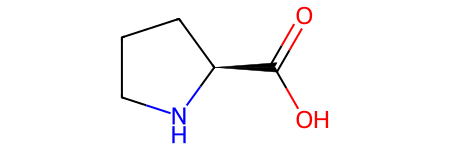

In [100]:
molecule = Chem.MolFromFASTA('P')
molecule

#### add changes in polarity

In [101]:
# Function to extract property names from column names
def extract_property(column_name):
    return column_name.split('_')[0]

clinvar_filtered['changes']=''
for i in range(0,len(clinvar_filtered)):
    for column in clinvar_filtered.columns:
        if column.endswith('_WT'):
            if clinvar_filtered[column].loc[i] == 1:
                prop = extract_property(column)
                clinvar_filtered['changes'].loc[i]=clinvar_filtered['changes'].loc[i]+prop+'_'
        elif column.endswith('_MUT'):
            if clinvar_filtered[column].loc[i] == 1:
                if clinvar_filtered['changes'].str.contains('to').iloc[i] == False:
                    prop = extract_property(column)
                    clinvar_filtered['changes'].loc[i]=clinvar_filtered['changes'].loc[i]+'to_'+prop+'_'
                else:
                    prop = extract_property(column)
                    clinvar_filtered['changes'].loc[i]=clinvar_filtered['changes'].loc[i]+prop+'_'
    clinvar_filtered['changes'].loc[i] = clinvar_filtered['changes'].str[:-1].loc[i]

/var/folders/56/l75lqrhd7m97zxtpbdw9rbbc0000gp/T/ipykernel_1323/498000398.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_filtered['changes'].loc[i]=clinvar_filtered['changes'].loc[i]+prop+'_'
/var/folders/56/l75lqrhd7m97zxtpbdw9rbbc0000gp/T/ipykernel_1323/498000398.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_filtered['changes'].loc[i]=clinvar_filtered['changes'].loc[i]+'to_'+prop+'_'
/var/folders/56/l75lqrhd7m97zxtpbdw9rbbc0000gp/T/ipykernel_1323/498000398.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [102]:
clinvar_filtered

,#CHROM,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,...,special_assign_WT,aliphatic_assign_MUT,aromatic_assign_MUT,hydrophobic_assign_MUT,positive_assign_MUT,negative_assign_MUT,neutral_assign_MUT,polar_assign_MUT,special_assign_MUT,changes
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,Leber_congenital_amaurosis_8,...,1,0,0,0,0,0,1,1,0,special_to_neutral_polar
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,Retinitis_pigmentosa_12,...,0,0,0,0,1,0,0,1,0,neutral_polar_to_positive_polar
2,1,197429467,1963628,G,A,NaN,NaN,NaN,2017299,Retinitis_pigmentosa_12|Leber_congenital_amaurosis_8,...,1,0,0,0,1,0,0,1,0,special_to_positive_polar
3,1,197429468,2202910,G,C,NaN,NaN,NaN,1928560,Retinitis_pigmentosa_12|Leber_congenital_amaurosis_8,...,1,1,0,1,0,0,0,0,0,special_to_aliphatic_hydrophobic
4,1,197429473,978993,G,T,NaN,NaN,NaN,967053,Autosomal_recessive_retinitis_pigmentosa,...,0,0,1,1,0,0,0,0,0,aliphatic_hydrophobic_to_aromatic_hydrophobic
5,1,197429555,191357,G,A,NaN,NaN,NaN,189156,Retinitis_pigmentosa,...,1,0,1,1,0,0,0,0,0,special_to_aromatic_hydrophobic
6,1,197429581,813170,G,C,NaN,NaN,NaN,801275,Leber_congenital_amaurosis,...,0,0,0,0,0,0,0,0,1,aliphatic_hydrophobic_to_special
7,1,197429587,1017521,T,C,NaN,NaN,NaN,1002377,Retinitis_pigmentosa_12|Leber_congenital_amaurosis_8,...,1,0,0,0,1,0,0,1,0,special_to_positive_polar
8,1,197429605,2093427,G,C,NaN,NaN,NaN,2156507,Leber_congenital_amaurosis_8|Retinitis_pigmentosa_12,...,1,0,0,0,1,0,0,1,0,special_to_positive_polar
9,1,197429614,427863,T,C,NaN,NaN,NaN,418814,Leber_congenital_amaurosis|Leber_congenital_amaurosis_8|Retinitis_pigmentosa_12|Leber_congenital_amaurosis_1|Pigmented_paravenous_retinochoroidal_atrophy,...,1,0,0,0,1,0,0,1,0,special_to_positive_polar


In [103]:
clinvar_filtered['changes'].value_counts()

special_to_positive_polar                         2177
aliphatic_hydrophobic_to_aliphatic_hydrophobic    2099
aliphatic_hydrophobic_to_special                  1705
positive_polar_to_special                         1658
special_to_aliphatic_hydrophobic                  1605
aliphatic_hydrophobic_to_neutral_polar            1571
special_to_neutral_polar                          1538
positive_polar_to_neutral_polar                   1398
special_to_aromatic_hydrophobic                   1320
special_to_negative_polar                         1212
neutral_polar_to_positive_polar                   1195
neutral_polar_to_aliphatic_hydrophobic            1027
aromatic_hydrophobic_to_special                    894
positive_polar_to_positive_polar                   870
neutral_polar_to_special                           819
negative_polar_to_positive_polar                   818
aliphatic_hydrophobic_to_positive_polar            761
positive_polar_to_aromatic_hydrophobic             671
aromatic_h

### one-hot encoded and separation for columns: foldx & secondary structure (H,E,T,S,G,B,I) & is_catalytic & blosum62 (conservative & non-conservative)

In [104]:
clinvar_expanded = clinvar_filtered.copy()

In [105]:
one_hot = pd.get_dummies(clinvar_expanded['secondary_structure'], prefix='ss')

In [106]:
clinvar_expanded = pd.concat([clinvar_expanded, one_hot], axis=1)

In [107]:
clinvar_expanded['is_catalytic'] = clinvar_expanded['is_catalytic'].astype(int)

In [108]:
clinvar_expanded['is_catalytic']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
        ..
31033    0
31034    0
31035    0
31036    1
31037    0
31038    0
31039    0
31040    0
31041    0
31042    0
31043    0
31044    0
31045    0
31046    0
31047    0
31048    0
31049    0
31050    0
31051    0
31052    0
31053    0
31054    0
31055    0
31056    0
31057    0
Name: is_catalytic, Length: 31058, dtype: int64

In [109]:
clinvar_expanded['is_catalytic'].value_counts()

0    30827
1      231
Name: is_catalytic, dtype: int64

In [110]:
clinvar_expanded['BLOSUM62'].isnull().sum()

0

In [111]:
# Example dataframe
df = pd.DataFrame({'BLOSUM62': [-2, 5, 0, -1, 11, -4, 3, -3, 7]})

# Create new columns and assign NaN values
df['conservative_changes'] = np.nan
df['nonconservative_changes'] = np.nan

# Set values based on conditions
df.loc[df['BLOSUM62'].between(0, 11), 'conservative_changes'] = df['BLOSUM62']
df.loc[df['BLOSUM62'].between(-4, -1), 'nonconservative_changes'] = df['BLOSUM62'].abs()

print(df)

   BLOSUM62  conservative_changes  nonconservative_changes
0        -2                   NaN                      2.0
1         5                   5.0                      NaN
2         0                   0.0                      NaN
3        -1                   NaN                      1.0
4        11                  11.0                      NaN
5        -4                   NaN                      4.0
6         3                   3.0                      NaN
7        -3                   NaN                      3.0
8         7                   7.0                      NaN


In [112]:
clinvar_expanded['BLOSUM62_nonNeg'] = clinvar_expanded['BLOSUM62'].apply(lambda x: max(0, x + 4))

In [113]:
clinvar_expanded.columns.to_list()

['#CHROM',
 'POS',
 'ID',
 'REF',
 'ALT',
 'AF_ESP',
 'AF_EXAC',
 'AF_TGP',
 'ALLELEID',
 'CLNDN',
 'CLNDNINCL',
 'CLNDISDB',
 'CLNDISDBINCL',
 'CLNHGVS',
 'CLNREVSTAT',
 'CLNSIG',
 'CLNSIGCONF',
 'CLNSIGINCL',
 'CLNVC',
 'CLNVCSO',
 'CLNVI',
 'DBVARID',
 'MC',
 'ORIGIN',
 'RS',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Gene',
 'Feature_type',
 'Feature',
 'BIOTYPE',
 'EXON',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'DISTANCE',
 'STRAND',
 'VARIANT_CLASS',
 'SYMBOL_SOURCE',
 'HGNC_ID',
 'CANONICAL',
 'MANE_SELECT',
 'MANE_PLUS_CLINICAL',
 'ENSP',
 'SWISSPROT',
 'TREMBL',
 'UNIPARC',
 'UNIPROT_ISOFORM',
 'RefSeq',
 'SIFT',
 'PolyPhen',
 'DOMAINS',
 'CLIN_SIG',
 'SOMATIC',
 'PHENO',
 'Conservation',
 'BLOSUM62',
 'GENEINFO_NAME',
 'GENEINFO_ID',
 'RefSeq_noversion',
 'UniProt_IDs',
 'PDB_path',
 'Residue_position',
 'Residue',
 'DSSP_path',
 'intra_contacts',
 'is_catalytic',
 'pLDDT

In [114]:
clinvar_expanded['DOMAINS'].isnull().sum()

2

In [115]:
clinvar_expanded['CANONICAL'].value_counts()

YES    30516
Name: CANONICAL, dtype: int64

In [116]:
clinvar_expanded['MANE_PLUS_CLINICAL'].value_counts()

NM_001371246.1    185
NM_014191.4       115
NM_001080463.2     50
NM_004992.4        43
NM_001099404.2     38
NM_003494.4        30
NM_001159702.3     17
NM_000828.5        12
NM_001006657.2      9
NM_030813.6         8
NM_015359.6         6
NM_001369387.1      6
NM_017890.5         5
NM_033056.4         5
NM_133379.5         4
NM_001365677.2      2
NM_005888.4         2
NM_001164507.2      2
NM_005709.4         1
NM_001329556.3      1
NM_001394928.1      1
Name: MANE_PLUS_CLINICAL, dtype: int64

In [117]:
clinvar_expanded.loc[31055]

#CHROM                                                                    Y
POS                                                                 2787515
ID                                                                   492908
REF                                                                       C
ALT                                                                       A
AF_ESP                                                                  NaN
AF_EXAC                                                                 NaN
AF_TGP                                                                  NaN
ALLELEID                                                             485861
CLNDN                                                  46,XY_sex_reversal_1
CLNDNINCL                                                               NaN
CLNDISDB                  MONDO:MONDO:0020712,MedGen:C2748896,OMIM:40004...
CLNDISDBINCL                                                            NaN
CLNHGVS     

In [118]:
clinvar_expanded['PhenotypeClass'].isnull().sum()

24929

In [119]:
clinvar_expanded['CLNDN'] = clinvar_expanded['CLNDN'].str.split('|')

In [120]:
clinvar_expanded['CLNDN'].value_counts()

[Early_infantile_epileptic_encephalopathy_with_suppression_bursts]                                                                                                                                                                                                                422
[Hypercholesterolemia,_familial,_1]                                                                                                                                                                                                                                               367
[Inborn_genetic_diseases]                                                                                                                                                                                                                                                         354
[Ehlers-Danlos_syndrome,_type_4]                                                                                                                                      

In [2]:
clinvar_expanded = pd.read_pickle('/Users/penaguka/Documents/phd/clinvar_expanded.pkl')

In [3]:
# Initialize an empty dictionary
disease_dict = {}
disease_counts = {}


# Iterate over the values in 'CLNDN' column
for value in clinvar_expanded['CLNDN']:
    for i in range(0,len(value)):
        if ',' in value[i]:
            # Split the value into key and comma-separated values
            key, *values = value[i].split(',')
            # Strip whitespace from the key
            key = key.strip()
            for j in range(0,len(values)):
                if key in disease_dict:
                    disease_dict[key].append(values[j])
                else:
                    disease_dict[key] = [values[j]]
            if key in disease_counts:
                disease_counts[key] += 1
            else:
                disease_counts[key] = 1
                
        else: 
            # If the value does not contain a comma, create a new key with an empty list
            if value[i] in disease_dict:
                disease_counts[value[i]] += 1
            else:
                disease_dict[value[i]] = []
                disease_counts[value[i]] = 1

In [122]:
disease_dict

{'Leber_congenital_amaurosis_8': [],
 'Retinitis_pigmentosa_12': [],
 'Autosomal_recessive_retinitis_pigmentosa': [],
 'Retinitis_pigmentosa': [],
 'Leber_congenital_amaurosis': [],
 'Leber_congenital_amaurosis_1': [],
 'Pigmented_paravenous_retinochoroidal_atrophy': [],
 'Retinal_dystrophy': [],
 'Macular_dystrophy': ['_retinal', '_4'],
 'Immunodeficiency_105': [],
 'Microcephaly_20': ['_primary',
  '_autosomal_recessive',
  '_primary',
  '_autosomal_recessive'],
 'Lethal_fetal_cerebrorenogenitourinary_agenesis/hypoplasia_syndrome': [],
 'Orofaciodigital_syndrome_V': [],
 'Intellectual_disability': ['_autosomal_recessive_12',
  '_severe',
  '_autosomal_recessive_12',
  '_autosomal_recessive_12',
  '_autosomal_dominant_52',
  '_autosomal_dominant_52',
  '_autosomal_dominant_14',
  '_autosomal_dominant_14',
  '_autosomal_dominant_14',
  '_autosomal_dominant_14',
  '_autosomal_dominant_14',
  '_autosomal_dominant_14',
  '_autosomal_dominant_14',
  '_autosomal_dominant_14',
  '_autosomal_

In [226]:
import csv


# Save dictionary as a CSV file
with open('disease_dict_clinvar.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(disease_dict.keys())
    writer.writerow(disease_dict.values())

In [331]:
disease_dict

{'\ufeffLeber_congenital_amaurosis_8': '[]',
 'Retinitis_pigmentosa_12': '[]',
 'Autosomal_recessive_retinitis_pigmentosa': '[]',
 'Retinitis_pigmentosa': '[]',
 'Leber_congenital_amaurosis': '[]',
 'Leber_congenital_amaurosis_1': '[]',
 'Pigmented_paravenous_retinochoroidal_atrophy': '[]',
 'Retinal_dystrophy': '[]',
 'Macular_dystrophy': '[]',
 'Immunodeficiency_105': '[]',
 'Microcephaly_20': "['_primary', '_autosomal_recessive', '_primary', '_autosomal_recessive']",
 'Lethal_fetal_cerebrorenogenitourinary_agenesis/hypoplasia_syndrome': '[]',
 'Orofaciodigital_syndrome_V': '[]',
 'Intellectual_disability': "['_X-linked_50', '_X-linked_50']",
 'Developmental_and_epileptic_encephalopathy': "['_15', '_18', '_18', '_23', '_38', '_18', '_18', '_54', '_54', '_54', '_54', '_69', '_69', '_69', '_69', '_69', '_32', '_32', '_32', '_32', '_32', '_32', '_32', '_32', '_32', '_32', '_32', '_1', '_32', '_32', '_32', '_32', '_32', '_32', '_57', '_57', '_57', '_57', '_57', '_11', '_11', '_11', '_11'

In [123]:
len(disease_dict)

5188

In [4]:
disease_counts

{'Leber_congenital_amaurosis_8': 99,
 'Retinitis_pigmentosa_12': 81,
 'Autosomal_recessive_retinitis_pigmentosa': 19,
 'Retinitis_pigmentosa': 103,
 'Leber_congenital_amaurosis': 41,
 'Leber_congenital_amaurosis_1': 33,
 'Pigmented_paravenous_retinochoroidal_atrophy': 6,
 'Retinal_dystrophy': 101,
 'Macular_dystrophy': 10,
 'Immunodeficiency_105': 1,
 'Microcephaly_20': 2,
 'Lethal_fetal_cerebrorenogenitourinary_agenesis/hypoplasia_syndrome': 1,
 'Orofaciodigital_syndrome_V': 1,
 'Intellectual_disability': 828,
 'Developmental_and_epileptic_encephalopathy': 945,
 'Aggressive_behavior': 1,
 'Frequent_falls': 1,
 'Difficulty_walking': 3,
 'Prolonged_neonatal_jaundice': 1,
 'Leukodystrophy': 26,
 'Leukoencephalopathy_with_vanishing_white_matter_3': 2,
 'Vanishing_white_matter_disease': 20,
 'Familial_porphyria_cutanea_tarda': 4,
 'Porphyria_cutanea_tarda': 1,
 'Hepatoerythropoietic_porphyria': 2,
 'Spastic_paraplegia': 57,
 'Neurodevelopmental_disorder_with_progressive_spasticity_and_brai

In [124]:
disease_counts

{'Leber_congenital_amaurosis_8': 99,
 'Retinitis_pigmentosa_12': 81,
 'Autosomal_recessive_retinitis_pigmentosa': 19,
 'Retinitis_pigmentosa': 103,
 'Leber_congenital_amaurosis': 41,
 'Leber_congenital_amaurosis_1': 33,
 'Pigmented_paravenous_retinochoroidal_atrophy': 6,
 'Retinal_dystrophy': 101,
 'Macular_dystrophy': 10,
 'Immunodeficiency_105': 1,
 'Microcephaly_20': 2,
 'Lethal_fetal_cerebrorenogenitourinary_agenesis/hypoplasia_syndrome': 1,
 'Orofaciodigital_syndrome_V': 1,
 'Intellectual_disability': 828,
 'Developmental_and_epileptic_encephalopathy': 945,
 'Aggressive_behavior': 1,
 'Frequent_falls': 1,
 'Difficulty_walking': 3,
 'Prolonged_neonatal_jaundice': 1,
 'Leukodystrophy': 26,
 'Leukoencephalopathy_with_vanishing_white_matter_3': 2,
 'Vanishing_white_matter_disease': 20,
 'Familial_porphyria_cutanea_tarda': 4,
 'Porphyria_cutanea_tarda': 1,
 'Hepatoerythropoietic_porphyria': 2,
 'Spastic_paraplegia': 57,
 'Neurodevelopmental_disorder_with_progressive_spasticity_and_brai

In [5]:
sorted_word_counts = dict(sorted(disease_counts.items(), key=lambda x: x[1], reverse=True))

In [9]:
import csv


# Save dictionary as a CSV file
with open('/Users/penaguka/Documents/phd/thesis/disease_counts_clinvar.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(sorted_word_counts.keys())
    writer.writerow(sorted_word_counts.values())

In [126]:
sorted_word_counts

{'Developmental_and_epileptic_encephalopathy': 945,
 'Intellectual_disability': 828,
 'Marfan_syndrome': 760,
 'Familial_thoracic_aortic_aneurysm_and_aortic_dissection': 706,
 'Hereditary_cancer-predisposing_syndrome': 636,
 'Inborn_genetic_diseases': 630,
 'Ehlers-Danlos_syndrome': 607,
 'Early_infantile_epileptic_encephalopathy_with_suppression_bursts': 603,
 'Hypercholesterolemia': 539,
 'Cardiovascular_phenotype': 311,
 'Osteogenesis_imperfecta_type_I': 299,
 'Mucopolysaccharidosis': 286,
 'Niemann-Pick_disease': 280,
 'Seizures': 238,
 'Neurofibromatosis': 234,
 'Hereditary_factor_VIII_deficiency_disease': 211,
 'Charcot-Marie-Tooth_disease': 198,
 'Neoplasm_of_the_large_intestine': 187,
 'Gastric_adenocarcinoma': 177,
 'Lung_adenocarcinoma': 177,
 'Severe_myoclonic_epilepsy_in_infancy': 168,
 'Phenylketonuria': 165,
 'Anemia': 162,
 'Familial_hypercholesterolemia': 162,
 'Breast_neoplasm': 160,
 'Malignant_neoplasm_of_body_of_uterus': 153,
 'Transitional_cell_carcinoma_of_the_bla

In [234]:
len(disease_counts)

5188

In [127]:
total_sum = sum(disease_counts.values())
total_sum

42769

In [128]:
# Calculate percentage of missing values
missing_values = clinvar_expanded.isnull().sum()
percentage_missing = (missing_values / len(clinvar_expanded)) * 100

# Create a new list to store column names with missing values > 70%
columns_with_missing = percentage_missing[percentage_missing > 70].index.tolist()
columns_with_missing

['AF_ESP',
 'AF_EXAC',
 'AF_TGP',
 'CLNDNINCL',
 'CLNDISDBINCL',
 'CLNSIGCONF',
 'CLNSIGINCL',
 'DBVARID',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'DISTANCE',
 'MANE_PLUS_CLINICAL',
 'SOMATIC',
 'PhenotypeClass']

In [129]:
# Add columns with molecular weights
clinvar_expanded['WT_MW'] = clinvar_expanded['WT'].map(molecular_weights)
clinvar_expanded['MUT_MW'] = clinvar_expanded['MUT'].map(molecular_weights)

In [19]:
clinvar_expanded

,CHR,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,MC,ORIGIN,RS,Allele,Consequence,IMPACT,GENEID,Gene,Feature_type,Feature,BIOTYPE,EXON,INTRON,HGVSc,HGVSp,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,DISTANCE,STRAND,VARIANT_CLASS,SYMBOL_SOURCE,HGNC_ID,CANONICAL,MANE_SELECT,MANE_PLUS_CLINICAL,ENSP,SWISSPROT,TREMBL,UNIPARC,UNIPROT_ISOFORM,RefSeq,SIFT,PolyPhen,DOMAINS,CLIN_SIG,SOMATIC,PHENO,Conservation,BLOSUM62,GENEINFO_NAME,GENEINFO_ID,RefSeq_noversion,UniProt_IDs,PDB_path,Residue_position,Residue,DSSP_path,intra_contacts,is_catalytic,pLDDT,secondary_structure,accessibility,total energy,Backbone Hbond,Sidechain Hbond,Van der Waals,Electrostatics,Solvation Polar,Solvation Hydrophobic,Van der Waals clashes,entropy sidechain,entropy mainchain,sloop_entropy,mloop_entropy,cis_bond,torsional clash,backbone clash,helix dipole,water bridge,disulfide,electrostatic kon,partial covalent bonds,energy Ionisation,Entropy Complex,PhenotypeClass,WT,MUT,aliphatic_assign_WT,aromatic_assign_WT,hydrophobic_assign_WT,positive_assign_WT,negative_assign_WT,neutral_assign_WT,polar_assign_WT,special_assign_WT,aliphatic_assign_MUT,aromatic_assign_MUT,hydrophobic_assign_MUT,positive_assign_MUT,negative_assign_MUT,neutral_assign_MUT,polar_assign_MUT,special_assign_MUT,changes,ss_B,ss_E,ss_G,ss_H,ss_I,ss_S,ss_T,BLOSUM62_nonNeg,WT_MW,MUT_MW,Phenotype1,Phenotype2,Phenotype3,Phenotype4,Phenotype5,Phenotype6,Phenotype7,Phenotype8,Phenotype9,Phenotype10,Phenotype11,Phenotype12,Phenotype13,Phenotype14,Phenotype15,Phenotype16,Phenotype17,Phenotype18,Phenotype19,Phenotype20,Phenotype21,Phenotype22,Phenotype23,Phenotype24,Phenotype25,Phenotype26,Phenotype27,Phenotype28,Phenotype29,Phenotype30,Phenotype31,Phenotype32,NumComorbidDiseases,prot_length,number_of_contacts,CLNDN_nosubtypes
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,[Leber_congenital_amaurosis_8],NaN,"MONDO:MONDO:0013453,MedGen:C3151202,OMIM:613835,Orphanet:65",NaN,NC_000001.11:g.197429459G>C,"criteria_provided,_single_submitter",Likely_pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,"SO:0001583|missense_variant,SO:0001619|non-coding_transcript_variant,SO:0001627|intron_variant",0,1571544334,C,missense_variant,MODERATE,CRB1,ENSG00000134376,Transcript,ENST00000367400,protein_coding,8/12,NaN,NaN,NaN,2848/4958,2687/4221,896/1406,C/S,tGt/tCt,CM1610693,NaN,1,SNV,HGNC,HGNC:2343,YES,NM_201253.3,NaN,ENSP00000356370,P82279.210,A0A7D6VM04.8,UPI0000073345,P82279-1,NM_201253.3,deleterious(0),probably_damaging(0.947),Gene3D:2.10.25.10&AFDB-ENSP_mappings:AF-P82279-F1.A&Pfam:PF00008&PROSITE_profiles:PS50026&PANTHER:PTHR24049&PANTHER:PTHR24049:SF1&SMART:SM00179&SMART:SM00181&CDD:cd00054,NaN,NaN,1,2.050,-1,CRB1,23418,NM_201253,"[P82279-1, A0A7D6VM04]",/ibex/scratch/projects/c2102/databases/alphafold/alphafold_mane/AF-P82279-F1-model_v4.pdb,896,Cys,/ibex/scratch/projects/c2102/databases/dssp/alphafold_mane_v4/AF-P82279-F1-model_v4.pdb.dssp,"[902, 903, 909, 910, 911, 912, 920, 921, 922]",0,78.820000,NaN,23,5.248440,0.073737,0.000000e+00,0.751425,0.000000,0.134081,1.298280,0.956765,-0.603521,-0.434252,0.0,0.0,0.0,0.113566,0.006548,0.000000e+00,0.0,2.95836,0.0,0.0,0.000000,0.0,[],Cys,Ser,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,special_to_neutral_polar,0,0,0,0,0,0,0,3,121.2,105.1,Leber_congenital_amaurosis_8,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,1406,9,[Leber_congenital_amaurosis_8]
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,[Retinitis_pigmentosa_12],NaN,"MONDO:MONDO:0010818,MedGen:C1838647,OMIM:600105,Orphanet:791",NaN,NC_000001.11:g.197429466T>G,"criteria_provided,_single_submitter",Likely_pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,"SO:0001583|missense_variant,SO:0001619|non-coding_transcript_variant,SO:0001627|intron_variant"

In [131]:
clinvar_expanded.isnull().sum()

#CHROM                        0
POS                           0
ID                            0
REF                           0
ALT                           0
AF_ESP                    30696
AF_EXAC                   28797
AF_TGP                    30732
ALLELEID                      0
CLNDN                         0
CLNDNINCL                 30999
CLNDISDB                      0
CLNDISDBINCL              30999
CLNHGVS                       0
CLNREVSTAT                    0
CLNSIG                        0
CLNSIGCONF                31058
CLNSIGINCL                30999
CLNVC                         0
CLNVCSO                       0
CLNVI                     16607
DBVARID                   31058
MC                            4
ORIGIN                      204
RS                        10131
Allele                        0
Consequence                   0
IMPACT                        0
SYMBOL                        0
Gene                          0
Feature_type                  0
Feature 

In [133]:
# Create empty columns for the maximum possible number of diseases
max_diseases = clinvar_expanded['CLNDN'].apply(len).max()
columns = [f'Phenotype{i+1}' for i in range(max_diseases)]
clinvar_expanded[columns] = None

# Iterate over each row
for index, row in clinvar_expanded.iterrows():
    diseases = row['CLNDN']
    for i, disease in enumerate(diseases):
        column_name = f'Phenotype{i+1}'
        clinvar_expanded.at[index, column_name] = disease

In [134]:
clinvar_expanded

,#CHROM,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,...,Phenotype23,Phenotype24,Phenotype25,Phenotype26,Phenotype27,Phenotype28,Phenotype29,Phenotype30,Phenotype31,Phenotype32
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,[Leber_congenital_amaurosis_8],...,None,None,None,None,None,None,None,None,None,None
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,[Retinitis_pigmentosa_12],...,None,None,None,None,None,None,None,None,None,None
2,1,197429467,1963628,G,A,NaN,NaN,NaN,2017299,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,None,None,None,None
3,1,197429468,2202910,G,C,NaN,NaN,NaN,1928560,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,None,None,None,None
4,1,197429473,978993,G,T,NaN,NaN,NaN,967053,[Autosomal_recessive_retinitis_pigmentosa],...,None,None,None,None,None,None,None,None,None,None
5,1,197429555,191357,G,A,NaN,NaN,NaN,189156,[Retinitis_pigmentosa],...,None,None,None,None,None,None,None,None,None,None
6,1,197429581,813170,G,C,NaN,NaN,NaN,801275,[Leber_congenital_amaurosis],...,None,None,None,None,None,None,None,None,None,None
7,1,197429587,1017521,T,C,NaN,NaN,NaN,1002377,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,None,None,None,None
8,1,197429605,2093427,G,C,NaN,NaN,NaN,2156507,"[Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12]",...,None,None,None,None,None,None,None,None,None,None
9,1,197429614,427863,T,C,NaN,NaN,NaN,418814,"[Leber_congenital_amaurosis, Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12, Leber_congenital_amaurosis_1, Pigmented_paravenous_retinochoroidal_atrophy]",...,None,None,None,None,None,None,None,None,None,None


In [135]:
max_diseases_row = clinvar_expanded['CLNDN'].apply(len).idxmax()
max_diseases_row_data = clinvar_expanded.loc[max_diseases_row]

In [136]:
max_diseases_row_data

#CHROM                                                                   17
POS                                                                 7673775
ID                                                                   376659
REF                                                                       C
ALT                                                                       G
AF_ESP                                                                  NaN
AF_EXAC                                                                 NaN
AF_TGP                                                                  NaN
ALLELEID                                                             363538
CLNDN                     [Neoplasm_of_the_large_intestine, Prostate_ade...
CLNDNINCL                                                               NaN
CLNDISDB                  Human_Phenotype_Ontology:HP:0100834,MONDO:MOND...
CLNDISDBINCL                                                            NaN
CLNHGVS     

In [139]:
clinvar_expanded['CLNDN'].loc[max_diseases_row]

['Neoplasm_of_the_large_intestine',
 'Prostate_adenocarcinoma',
 'Malignant_neoplasm_of_body_of_uterus',
 'Adrenocortical_carcinoma,_hereditary',
 'Familial_cancer_of_breast',
 'Bone_marrow_failure_syndrome_5',
 'Carcinoma_of_pancreas',
 'Choroid_plexus_papilloma',
 'Li-Fraumeni_syndrome_1',
 'Colorectal_cancer',
 'Glioma_susceptibility_1',
 'Basal_cell_carcinoma,_susceptibility_to,_7',
 'Bone_osteosarcoma',
 'Nasopharyngeal_carcinoma',
 'Hepatocellular_carcinoma',
 'Ovarian_serous_cystadenocarcinoma',
 'Neoplasm_of_brain',
 'Gastric_adenocarcinoma',
 'Glioblastoma',
 'Carcinoma_of_esophagus',
 'Pancreatic_adenocarcinoma',
 'Hereditary_cancer-predisposing_syndrome',
 'Breast_neoplasm',
 'Squamous_cell_lung_carcinoma',
 'Non-Hodgkin_lymphoma',
 'Li-Fraumeni_syndrome',
 'Squamous_cell_carcinoma_of_the_head_and_neck',
 'Malignant_melanoma_of_skin',
 'Papillary_renal_cell_carcinoma_type_1',
 'Lung_adenocarcinoma',
 'Squamous_cell_carcinoma_of_the_skin',
 'Transitional_cell_carcinoma_of_the

In [140]:
clinvar_expanded['NumComorbidDiseases'] = clinvar_expanded['CLNDN'].apply(len)

In [141]:
clinvar_expanded

,#CHROM,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,...,Phenotype24,Phenotype25,Phenotype26,Phenotype27,Phenotype28,Phenotype29,Phenotype30,Phenotype31,Phenotype32,NumComorbidDiseases
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,[Leber_congenital_amaurosis_8],...,None,None,None,None,None,None,None,None,None,1
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,[Retinitis_pigmentosa_12],...,None,None,None,None,None,None,None,None,None,1
2,1,197429467,1963628,G,A,NaN,NaN,NaN,2017299,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,None,None,None,2
3,1,197429468,2202910,G,C,NaN,NaN,NaN,1928560,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,None,None,None,2
4,1,197429473,978993,G,T,NaN,NaN,NaN,967053,[Autosomal_recessive_retinitis_pigmentosa],...,None,None,None,None,None,None,None,None,None,1
5,1,197429555,191357,G,A,NaN,NaN,NaN,189156,[Retinitis_pigmentosa],...,None,None,None,None,None,None,None,None,None,1
6,1,197429581,813170,G,C,NaN,NaN,NaN,801275,[Leber_congenital_amaurosis],...,None,None,None,None,None,None,None,None,None,1
7,1,197429587,1017521,T,C,NaN,NaN,NaN,1002377,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,None,None,None,2
8,1,197429605,2093427,G,C,NaN,NaN,NaN,2156507,"[Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12]",...,None,None,None,None,None,None,None,None,None,2
9,1,197429614,427863,T,C,NaN,NaN,NaN,418814,"[Leber_congenital_amaurosis, Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12, Leber_congenital_amaurosis_1, Pigmented_paravenous_retinochoroidal_atrophy]",...,None,None,None,None,None,None,None,None,None,5


In [142]:
clinvar_expanded['CLNDN'].value_counts()

[Early_infantile_epileptic_encephalopathy_with_suppression_bursts]                                                                                                                                                                                                                422
[Hypercholesterolemia,_familial,_1]                                                                                                                                                                                                                                               367
[Inborn_genetic_diseases]                                                                                                                                                                                                                                                         354
[Ehlers-Danlos_syndrome,_type_4]                                                                                                                                      

### count the values inside the lists in CLNDN indistinguishably of their order

In [146]:
CLNDN_counts = clinvar_expanded['CLNDN'].apply(frozenset).value_counts()

In [147]:
CLNDN_counts

(Familial_thoracic_aortic_aneurysm_and_aortic_dissection, Marfan_syndrome)                                                                                                                                                                                                           458
(Early_infantile_epileptic_encephalopathy_with_suppression_bursts)                                                                                                                                                                                                                   422
(Hypercholesterolemia,_familial,_1)                                                                                                                                                                                                                                                  367
(Inborn_genetic_diseases)                                                                                                                                    

### add protein length

In [148]:
protein_length_cache = {}

In [149]:
import requests

def get_protein_length(transcript_id, protein_length_cache):
    if transcript_id in protein_length_cache:
        # If the protein length is already cached, return it
        return protein_length_cache[transcript_id]
    
    url = f"https://rest.ensembl.org/sequence/id/{transcript_id}?type=protein"
    headers = {"Content-Type": "application/json"}

    response = requests.get(url, headers=headers)

    if response.ok:
        protein_sequence = response.json()['seq']
        protein_length = len(protein_sequence)
        
        protein_length_cache[transcript_id] = protein_length
        return protein_length
    else:
        print(f"Error retrieving protein length of {transcript_id}.")
        # Handle error if transcript ID is invalid or protein sequence is not available
        return None


In [150]:
clinvar_expanded['prot_length'] = clinvar_expanded['Feature'].apply(
    lambda transcript_id: get_protein_length(transcript_id, protein_length_cache)
)

In [152]:
# Function to calculate the number of contacts
def count_contacts(contact_list):
    return len(contact_list)

In [153]:
# Add 'number_of_contacts' column
clinvar_expanded['number_of_contacts'] = clinvar_expanded['intra_contacts'].apply(count_contacts)

In [154]:
clinvar_expanded

,#CHROM,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,...,Phenotype26,Phenotype27,Phenotype28,Phenotype29,Phenotype30,Phenotype31,Phenotype32,NumComorbidDiseases,prot_length,number_of_contacts
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,[Leber_congenital_amaurosis_8],...,None,None,None,None,None,None,None,1,1406,9
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,[Retinitis_pigmentosa_12],...,None,None,None,None,None,None,None,1,1406,7
2,1,197429467,1963628,G,A,NaN,NaN,NaN,2017299,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,None,2,1406,2
3,1,197429468,2202910,G,C,NaN,NaN,NaN,1928560,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,None,2,1406,2
4,1,197429473,978993,G,T,NaN,NaN,NaN,967053,[Autosomal_recessive_retinitis_pigmentosa],...,None,None,None,None,None,None,None,1,1406,6
5,1,197429555,191357,G,A,NaN,NaN,NaN,189156,[Retinitis_pigmentosa],...,None,None,None,None,None,None,None,1,1406,7
6,1,197429581,813170,G,C,NaN,NaN,NaN,801275,[Leber_congenital_amaurosis],...,None,None,None,None,None,None,None,1,1406,5
7,1,197429587,1017521,T,C,NaN,NaN,NaN,1002377,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,None,2,1406,9
8,1,197429605,2093427,G,C,NaN,NaN,NaN,2156507,"[Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12]",...,None,None,None,None,None,None,None,2,1406,6
9,1,197429614,427863,T,C,NaN,NaN,NaN,418814,"[Leber_congenital_amaurosis, Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12, Leber_congenital_amaurosis_1, Pigmented_paravenous_retinochoroidal_atrophy]",...,None,None,None,None,None,None,None,5,1406,12


In [155]:
clinvar_expanded['DOMAINS'].value_counts()

Gene3D:1.10.287.70&PDB-ENSP_mappings:7dtd.A&AFDB-ENSP_mappings:AF-P35498-F1.A&Pfam:PF00520&PANTHER:PTHR10037&PANTHER:PTHR10037:SF280&Superfamily:SSF81324                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [157]:
clinvar_expanded.columns.values.tolist()

['#CHROM',
 'POS',
 'ID',
 'REF',
 'ALT',
 'AF_ESP',
 'AF_EXAC',
 'AF_TGP',
 'ALLELEID',
 'CLNDN',
 'CLNDNINCL',
 'CLNDISDB',
 'CLNDISDBINCL',
 'CLNHGVS',
 'CLNREVSTAT',
 'CLNSIG',
 'CLNSIGCONF',
 'CLNSIGINCL',
 'CLNVC',
 'CLNVCSO',
 'CLNVI',
 'DBVARID',
 'MC',
 'ORIGIN',
 'RS',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Gene',
 'Feature_type',
 'Feature',
 'BIOTYPE',
 'EXON',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'DISTANCE',
 'STRAND',
 'VARIANT_CLASS',
 'SYMBOL_SOURCE',
 'HGNC_ID',
 'CANONICAL',
 'MANE_SELECT',
 'MANE_PLUS_CLINICAL',
 'ENSP',
 'SWISSPROT',
 'TREMBL',
 'UNIPARC',
 'UNIPROT_ISOFORM',
 'RefSeq',
 'SIFT',
 'PolyPhen',
 'DOMAINS',
 'CLIN_SIG',
 'SOMATIC',
 'PHENO',
 'Conservation',
 'BLOSUM62',
 'GENEINFO_NAME',
 'GENEINFO_ID',
 'RefSeq_noversion',
 'UniProt_IDs',
 'PDB_path',
 'Residue_position',
 'Residue',
 'DSSP_path',
 'intra_contacts',
 'is_catalytic',
 'pLDDT

In [158]:
# Define the keywords to search for
keywords = ['heart', 'cardio', 'cardia', 'long_QT', 'short_QT', 'intellectual_developmental_disorder', 'intellectual_disability', 'cancer', 'carcinoma', 'sarcoma', 'leuchemia', 'lymphoma', 'myeloma', 'glioma', 'neoplasm', 'blastoma', 'tumor', 'melanoma']

# Add a new column based on the annotation
clinvar_expanded['PhenotypeClass'] = clinvar_expanded['CLNDN'].apply(lambda x: ['heart_disease'] if any(keyword in str(x).lower() for keyword in keywords[:5]) else (['cancer'] if any(keyword in str(x).lower() for keyword in keywords[7:]) else(['intellectual_disability'] if any(keyword in str(x).lower() for keyword in keywords[5:7]) else [keyword for keyword in keywords if keyword in str(x).lower()])))


In [159]:
clinvar_expanded['PhenotypeClass'].value_counts()

[]                           27012
[cancer]                      1669
[intellectual_disability]     1339
[heart_disease]               1038
Name: PhenotypeClass, dtype: int64

In [218]:
# Define the keywords to search for
heart_keys = ['heart', 'cardio', 'cardia', 'long_QT', 'short_QT']
cancer_keys = ['cancer', 'carcinoma', 'sarcoma', 'leuchemia', 'lymphoma', 'myeloma', 'glioma', 'neoplasm', 'blastoma', 'tumor', 'melanoma']
intellectual_keys = ['intellectual_developmental_disorder', 'intellectual_disability']
keywords = ['hypercholesterolemia', 'charcot-marie-tooth', 'epileptic_encephalopathy']

In [219]:
clinvar_expanded['PhenotypeClass'] = clinvar_expanded['CLNDN'].apply(lambda x: (['heart_disease' for keyword in heart_keys if keyword in str(x).lower()] +
                                                                     ['cancer' for keyword in cancer_keys if keyword in str(x).lower()] +
                                                                     ['intellectual_disability' for keyword in intellectual_keys if keyword in str(x).lower()] +
                                                                     [keyword for keyword in keywords if keyword in str(x).lower()]))

In [209]:
# Add a new column based on the annotation
clinvar_expanded['PhenotypeClass'] = clinvar_expanded['CLNDN'].apply(lambda x: (['heart_disease' for keyword in heart_keys if keyword in str(x).lower()] +
                                                                     ['cancer' for keyword in cancer_keys if keyword in str(x).lower()] +
                                                                     ['intellectual_disability' for keyword in intellectual_keys if keyword in str(x).lower()] +
                                                                     ['Charcot-Marie-Tooth' if keywords[1] in str(x).lower() else None] +
                                                                     ['epileptic_encephalopathy' if keywords[2] in str(x).lower() else None]) or None)

In [211]:
clinvar_expanded['CLNDN'].value_counts()

[Early_infantile_epileptic_encephalopathy_with_suppression_bursts]                                                                                                                                                                                                                422
[Hypercholesterolemia,_familial,_1]                                                                                                                                                                                                                                               367
[Inborn_genetic_diseases]                                                                                                                                                                                                                                                         354
[Ehlers-Danlos_syndrome,_type_4]                                                                                                                                      

In [220]:
clinvar_expanded['PhenotypeClass'].value_counts()

[]                                                                  24423
[epileptic_encephalopathy]                                           1580
[intellectual_disability]                                            1274
[cancer]                                                             1125
[heart_disease]                                                       875
[charcot-marie-tooth]                                                 506
[hypercholesterolemia]                                                503
[cancer, cancer]                                                      291
[cancer, cancer, cancer]                                              120
[heart_disease, hypercholesterolemia]                                  73
[cancer, cancer, cancer, cancer]                                       61
[intellectual_disability, epileptic_encephalopathy]                    53
[heart_disease, cancer]                                                37
[cancer, cancer, cancer, cancer, cance

In [221]:
clinvar_expanded['CLNDN_nosubtypes'] = clinvar_expanded['CLNDN'].apply(lambda x: [item.split(',')[0] for item in x])

In [223]:
clinvar_expanded['CLNDN_nosubtypes'].apply(frozenset).value_counts()

(Intellectual_disability)                                                                                                                                            535
(Developmental_and_epileptic_encephalopathy)                                                                                                                         527
(Familial_thoracic_aortic_aneurysm_and_aortic_dissection, Marfan_syndrome)                                                                                           459
(Early_infantile_epileptic_encephalopathy_with_suppression_bursts)                                                                                                   422
(Hypercholesterolemia)                                                                                                                                               381
(Ehlers-Danlos_syndrome)                                                                                                                                   

In [224]:
clinvar_expanded['CLNDN'].apply(frozenset).value_counts()

(Familial_thoracic_aortic_aneurysm_and_aortic_dissection, Marfan_syndrome)                                                                                                                                                                                                           458
(Early_infantile_epileptic_encephalopathy_with_suppression_bursts)                                                                                                                                                                                                                   422
(Hypercholesterolemia,_familial,_1)                                                                                                                                                                                                                                                  367
(Inborn_genetic_diseases)                                                                                                                                    

In [222]:
clinvar_expanded[['CLNDN','CLNDN_nosubtypes']]

,CLNDN,CLNDN_nosubtypes
0,[Leber_congenital_amaurosis_8],[Leber_congenital_amaurosis_8]
1,[Retinitis_pigmentosa_12],[Retinitis_pigmentosa_12]
2,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]","[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]"
3,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]","[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]"
4,[Autosomal_recessive_retinitis_pigmentosa],[Autosomal_recessive_retinitis_pigmentosa]
5,[Retinitis_pigmentosa],[Retinitis_pigmentosa]
6,[Leber_congenital_amaurosis],[Leber_congenital_amaurosis]
7,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]","[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]"
8,"[Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12]","[Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12]"
9,"[Leber_congenital_amaurosis, Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12, Leber_congenital_amaurosis_1, Pigmented_paravenous_retinochoroidal_atrophy]","[Leber_congenital_amaurosis, Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12, Leber_congenital_amaurosis_1, Pigmented_paravenous_retinochoroidal_atrophy]"


In [225]:
clinvar_expanded.to_pickle('clinvar_expanded.pkl')

In [228]:
clinvar_expanded.columns.to_list()

['#CHROM',
 'POS',
 'ID',
 'REF',
 'ALT',
 'AF_ESP',
 'AF_EXAC',
 'AF_TGP',
 'ALLELEID',
 'CLNDN',
 'CLNDNINCL',
 'CLNDISDB',
 'CLNDISDBINCL',
 'CLNHGVS',
 'CLNREVSTAT',
 'CLNSIG',
 'CLNSIGCONF',
 'CLNSIGINCL',
 'CLNVC',
 'CLNVCSO',
 'CLNVI',
 'DBVARID',
 'MC',
 'ORIGIN',
 'RS',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Gene',
 'Feature_type',
 'Feature',
 'BIOTYPE',
 'EXON',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'DISTANCE',
 'STRAND',
 'VARIANT_CLASS',
 'SYMBOL_SOURCE',
 'HGNC_ID',
 'CANONICAL',
 'MANE_SELECT',
 'MANE_PLUS_CLINICAL',
 'ENSP',
 'SWISSPROT',
 'TREMBL',
 'UNIPARC',
 'UNIPROT_ISOFORM',
 'RefSeq',
 'SIFT',
 'PolyPhen',
 'DOMAINS',
 'CLIN_SIG',
 'SOMATIC',
 'PHENO',
 'Conservation',
 'BLOSUM62',
 'GENEINFO_NAME',
 'GENEINFO_ID',
 'RefSeq_noversion',
 'UniProt_IDs',
 'PDB_path',
 'Residue_position',
 'Residue',
 'DSSP_path',
 'intra_contacts',
 'is_catalytic',
 'pLDDT

### gnomAD variants

Retrieval:
1. Downloaded form gnomAD website: https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/liftover_grch38/vcf/exomes/gnomad.exomes.r2.1.1.sites.liftover_grch38.vcf.bgz  
   `- /ibex/scratch/projects/c2102/databases/gnomad_v2.1.1_liftover/gnomad.exomes.r2.1.1.sites.liftover_grch38.vcf.bgz`

3. Filtered by quality and allele frequency  
   `- bcftools view -f PASS -i 'AF>0.05' gnomad.exomes.r2.1.1.sites.liftover_grch38.vcf.bgz > pass_common.vcf`

2. Split into chromosomes with bcftools  
   `- /ibex/scratch/projects/c2102/databases/gnomad_v2.1.1_liftover/chr##.vcf`

Processing:
1. Annotated with VEP  
   `- /ibex/scratch/projects/c2102/databases/gnomad_v2.1.1_liftover/chr#/chr#_x##.vcf.vep`

2. Select variants that contain 'missense_variant' in the 'Consequence' column (from VEP)  

3. Filter out variants that contain 'pathogenic' or 'risk' in the clinical significance (CLIN_SIG column from VEP)  

6. Select variants where the RefSeq ID (RefSeq column) is equal to the transcript indicated in the MANE_SELECT or MANE_PLUS_CLINICAL columns (from VEP)  

7. Obtained UniProt IDs for each variant, from two sources (sometimes there's more than 1 UniProt ID for a given transcript):  
   a) UNIPROT_ISOFORM column (from VEP)  
   b) UniProt database (/ibex/projects/c2102/databases/uniprot/2023_02/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz)  

8. Get the AlphaFold model for each transcript, from two sources:  
   a) MANE dataset from the AlphaFold Database (/ibex/scratch/projects/c2102/databases/alphafold/alphafold_human_v4)  
   b) Regular AlphaFold Database (/ibex/scratch/projects/c2102/databases/alphafold/alphafold_mane)  

   Checked that the sequence length and residue match.  

9. Obtained intra-molecular contacts (6 Angstroms away)  

10. Obtained catalytic sites for residue of interest and residues 8 Angstroms away (with function from variant_annotator.structure_features.catalyticSites) 

11. Annotated AlphaFold models with DSSP to calculate secondary structure and surface accessible area for every residue, and extracted the values for the variants.  

12. Extracted pLDDT scores in a window of 5 residues centered around the residue of interest (proxy for disorder)  

13. Annotated with FoldX  

In [5]:
gnomad_variants = pd.read_pickle('variants/gnomad_variants.pkl')

In [4]:
gnomad_variants

,#CHROM,POS,ID,REF,ALT,AC,AF,AN,QD,variant_type,...,cis_bond,torsional clash,backbone clash,helix dipole,water bridge,disulfide,electrostatic kon,partial covalent bonds,energy Ionisation,Entropy Complex
0,chr1,11706367,rs11121804,C,T,39444,0.158732,248494,13.47,mixed,...,0.0,-0.018940,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
1,chr1,11790870,rs2274976,C,T,13949,0.0555184,251250,14.18,snv,...,0.0,-0.165854,-0.304761,3.235800e-01,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2,chr1,11824498,rs198400,A,G,250947,0.999399,251098,33.49,snv,...,0.0,-0.140793,-1.049150,-7.725940e-03,0.0,0.0,0.0,0.0,0.000000e+00,0.0
3,chr1,11847591,rs5063,C,T,14048,0.0558586,251492,13.96,snv,...,0.0,-0.104118,0.236702,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
4,chr1,11949899,rs7551175,G,A,45490,0.180978,251356,14.94,snv,...,0.0,0.006133,0.028216,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15936,chrX,72140250,rs7061150,C,T,12196,0.0674621,180783,19.16,snv,...,0.0,0.031276,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
15937,chrY,6246522,rs201475959,A,G,1025,0.0780952,13125,30.14,snv,...,0.0,-0.000050,-0.708370,-4.440890e-16,0.0,0.0,0.0,0.0,0.000000e+00,0.0
15938,chrY,12720687,rs7067496,G,T,6033,0.0894759,67426,32.95,snv,...,0.0,-0.002779,-0.131799,3.340370e-01,0.0,0.0,0.0,0.0,-8.881780e-16,0.0
15939,chrY,22180292,rs1478920645,G,T,1,0.142857,7,15.53,snv,...,0.0,0.002249,0.067966,-2.492200e-01,0.0,0.0,0.0,0.0,-1.996460e-03,0.0


In [7]:
gnomad_variants['#CHROM'].value_counts()

chr1     1709
chr19    1327
chr11    1250
chr6     1235
chr2     1003
chr17     903
chr7      789
chr12     721
chr5      719
chr3      717
chr10     702
chr4      655
chr16     641
chr9      614
chr15     558
chr8      539
chr14     498
chr20     363
chrX      301
chr18     298
chr21     202
chr13     193
chrY        4
Name: #CHROM, dtype: int64

In [65]:
gnomad_variants.columns.values.tolist()

['#CHROM',
 'POS',
 'ID',
 'REF',
 'ALT',
 'AC',
 'AF',
 'AN',
 'QD',
 'variant_type',
 'vep',
 'flags',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Gene',
 'Feature_type',
 'Feature',
 'BIOTYPE',
 'EXON',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'DISTANCE',
 'STRAND',
 'VARIANT_CLASS',
 'SYMBOL_SOURCE',
 'HGNC_ID',
 'CANONICAL',
 'MANE_SELECT',
 'MANE_PLUS_CLINICAL',
 'ENSP',
 'SWISSPROT',
 'TREMBL',
 'UNIPARC',
 'UNIPROT_ISOFORM',
 'RefSeq',
 'SIFT',
 'PolyPhen',
 'DOMAINS',
 'CLIN_SIG',
 'SOMATIC',
 'PHENO',
 'Conservation',
 'BLOSUM62',
 'RefSeq_noversion',
 'UniProt_IDs',
 'PDB_path',
 'Residue_position',
 'Residue',
 'DSSP_path',
 'intra_contacts',
 'is_catalytic',
 'pLDDT',
 'secondary_structure',
 'accessibility',
 'total energy',
 'Backbone Hbond',
 'Sidechain Hbond',
 'Van der Waals',
 'Electrostatics',
 'Solvation Polar',
 'Solvation Hydrophobic',
 'Van der Waals clashes',

In [273]:
gnomad_variants.loc[2]

#CHROM                                                                 chr1
POS                                                                11824498
ID                                                                 rs198400
REF                                                                       A
ALT                                                                       G
AC                                                                   250947
AF                                                                 0.999399
AN                                                                   251098
QD                                                                    33.49
variant_type                                                            snv
vep                       G|missense_variant|MODERATE|CLCN6|ENSG00000011...
flags                     [VQSR_POSITIVE_TRAIN_SITE, rf_positive_label, ...
Allele                                                                    G
Consequence 

In [5]:
gnomad_variants['variant_type'].value_counts()

snv          11231
multi-snv     4019
mixed          691
Name: variant_type, dtype: int64

In [6]:
gnomad_variants['Consequence'].value_counts()

missense_variant                          15614
missense_variant&splice_region_variant      327
Name: Consequence, dtype: int64

In [7]:
# Calculate percentage of missing values
missing_values = gnomad_variants.isnull().sum()
percentage_missing = (missing_values / len(gnomad_variants)) * 100

# Create a new list to store column names with missing values > 70%
columns_with_missing = percentage_missing[percentage_missing > 70].index.tolist()
columns_with_missing

['INTRON',
 'HGVSc',
 'HGVSp',
 'DISTANCE',
 'MANE_PLUS_CLINICAL',
 'TREMBL',
 'CLIN_SIG']

In [12]:
gnomad_variants.isnull().sum()

#CHROM                        0
POS                           0
ID                            0
REF                           0
ALT                           0
AC                            0
AF                            0
AN                            0
QD                            0
variant_type                  0
vep                           0
flags                         0
Allele                        0
Consequence                   0
IMPACT                        0
SYMBOL                        3
Gene                          0
Feature_type                  0
Feature                       0
BIOTYPE                       0
EXON                          0
INTRON                    15941
HGVSc                     15941
HGVSp                     15941
cDNA_position                 0
CDS_position                  0
Protein_position              0
Amino_acids                   0
Codons                        0
Existing_variation           10
DISTANCE                  15941
STRAND  

In [13]:
gnomad_variants.shape

(15941, 85)

### add polarities & change in size & add number of contacts

In [14]:
gnomad_variants[['WT', 'MUT']] = gnomad_variants['Amino_acids'].str.split('/', expand=True)

In [17]:
# Convert one-letter code to three-letter code
gnomad_variants['WT'] = gnomad_variants['WT'].map(protein_letters_1to3)
gnomad_variants['MUT'] = gnomad_variants['MUT'].map(protein_letters_1to3)

In [18]:
gnomad_variants.loc[3]

#CHROM                                                                 chr1
POS                                                                11847591
ID                                                                   rs5063
REF                                                                       C
ALT                                                                       T
AC                                                                    14048
AF                                                                0.0558586
AN                                                                   251492
QD                                                                    13.96
variant_type                                                            snv
vep                       T|downstream_gene_variant|MODIFIER|CLCN6|ENSG0...
flags                     [VQSR_POSITIVE_TRAIN_SITE, rf_positive_label, ...
Allele                                                                    T
Consequence 

In [19]:
aliphatic = [
    'Ala',
    'Ile',
    'Leu',
    'Met',
    'Val'
]

aromatic = [
    'Phe',
    'Trp',
    'Tyr'
]

hydrophobic = aliphatic + aromatic

positive = [
    'Arg',
    'His',
    'Lys'
]

negative = [
    'Asp',
    'Glu'
]

neutral = [
    'Asn',
    'Gln',
    'Thr',
    'Ser'
]

polar = positive + negative + neutral

special = [
    'Pro',
    'Gly',
    'Cys'
]

In [20]:
gnomad_variants['aliphatic_assign_WT'] = gnomad_variants.WT.isin(aliphatic).apply(
                            lambda x: 1 if x else 0)
features_vector = []
gnomad_variants['aromatic_assign_WT'] = gnomad_variants.WT.isin(aromatic).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['hydrophobic_assign_WT'] = gnomad_variants.WT.isin(hydrophobic).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['positive_assign_WT'] = gnomad_variants.WT.isin(positive).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['negative_assign_WT'] = gnomad_variants.WT.isin(negative).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['neutral_assign_WT'] = gnomad_variants.WT.isin(neutral).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['polar_assign_WT'] = gnomad_variants.WT.isin(polar).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['special_assign_WT'] = gnomad_variants.WT.isin(special).apply(
                            lambda x: 1 if x else 0)

In [21]:
gnomad_variants['aliphatic_assign_MUT'] = gnomad_variants.MUT.isin(aliphatic).apply(
                            lambda x: 1 if x else 0)
features_vector = []
gnomad_variants['aromatic_assign_MUT'] = gnomad_variants.MUT.isin(aromatic).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['hydrophobic_assign_MUT'] = gnomad_variants.MUT.isin(hydrophobic).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['positive_assign_MUT'] = gnomad_variants.MUT.isin(positive).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['negative_assign_MUT'] = gnomad_variants.MUT.isin(negative).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['neutral_assign_MUT'] = gnomad_variants.MUT.isin(neutral).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['polar_assign_MUT'] = gnomad_variants.MUT.isin(polar).apply(
                            lambda x: 1 if x else 0)
gnomad_variants['special_assign_MUT'] = gnomad_variants.MUT.isin(special).apply(
                            lambda x: 1 if x else 0)

In [22]:
gnomad_variants

,#CHROM,POS,ID,REF,ALT,AC,AF,AN,QD,variant_type,...,polar_assign_WT,special_assign_WT,aliphatic_assign_MUT,aromatic_assign_MUT,hydrophobic_assign_MUT,positive_assign_MUT,negative_assign_MUT,neutral_assign_MUT,polar_assign_MUT,special_assign_MUT
0,chr1,11706367,rs11121804,C,T,39444,0.158732,248494,13.47,mixed,...,0,0,0,1,1,0,0,0,0,0
1,chr1,11790870,rs2274976,C,T,13949,0.0555184,251250,14.18,snv,...,1,0,0,0,0,0,0,1,1,0
2,chr1,11824498,rs198400,A,G,250947,0.999399,251098,33.49,snv,...,1,0,0,0,0,0,0,0,0,1
3,chr1,11847591,rs5063,C,T,14048,0.0558586,251492,13.96,snv,...,0,0,1,0,1,0,0,0,0,0
4,chr1,11949899,rs7551175,G,A,45490,0.180978,251356,14.94,snv,...,0,0,0,0,0,0,0,1,1,0
5,chr1,11950412,rs2273285,G,T,21778,0.0866876,251224,14.57,snv,...,0,0,0,0,0,0,0,1,1,0
6,chr1,12022277,rs11553925,A,T,49896,0.199681,249878,15.72,snv,...,1,0,0,0,0,0,0,1,1,0
7,chr1,12022404,rs11588712,C,T,27588,0.119221,231402,15.28,snv,...,0,1,0,0,0,0,0,1,1,0
8,chr1,12022869,rs2295283,A,G,165360,0.682133,242416,23.34,snv,...,1,0,0,0,0,0,1,0,1,0
9,chr1,12192898,rs1061622,T,G,54148,0.216294,250344,16.18,snv,...,0,0,0,0,0,1,0,0,1,0


#### add changes in polarity

In [23]:
# Function to extract property names from column names
def extract_property(column_name):
    return column_name.split('_')[0]

gnomad_variants['changes']=''
for i in range(0,len(gnomad_variants)):
    for column in gnomad_variants.columns:
        if column.endswith('_WT'):
            if gnomad_variants[column].loc[i] == 1:
                prop = extract_property(column)
                gnomad_variants['changes'].loc[i]=gnomad_variants['changes'].loc[i]+prop+'_'
        elif column.endswith('_MUT'):
            if gnomad_variants[column].loc[i] == 1:
                if gnomad_variants['changes'].str.contains('to').iloc[i] == False:
                    prop = extract_property(column)
                    gnomad_variants['changes'].loc[i]=gnomad_variants['changes'].loc[i]+'to_'+prop+'_'
                else:
                    prop = extract_property(column)
                    gnomad_variants['changes'].loc[i]=gnomad_variants['changes'].loc[i]+prop+'_'
    gnomad_variants['changes'].loc[i] = gnomad_variants['changes'].str[:-1].loc[i]

/var/folders/56/l75lqrhd7m97zxtpbdw9rbbc0000gp/T/ipykernel_1323/1241981568.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomad_variants['changes'].loc[i]=gnomad_variants['changes'].loc[i]+prop+'_'
/var/folders/56/l75lqrhd7m97zxtpbdw9rbbc0000gp/T/ipykernel_1323/1241981568.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomad_variants['changes'].loc[i]=gnomad_variants['changes'].loc[i]+'to_'+prop+'_'
/var/folders/56/l75lqrhd7m97zxtpbdw9rbbc0000gp/T/ipykernel_1323/1241981568.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

In [24]:
gnomad_variants

,#CHROM,POS,ID,REF,ALT,AC,AF,AN,QD,variant_type,...,special_assign_WT,aliphatic_assign_MUT,aromatic_assign_MUT,hydrophobic_assign_MUT,positive_assign_MUT,negative_assign_MUT,neutral_assign_MUT,polar_assign_MUT,special_assign_MUT,changes
0,chr1,11706367,rs11121804,C,T,39444,0.158732,248494,13.47,mixed,...,0,0,1,1,0,0,0,0,0,aliphatic_hydrophobic_to_aromatic_hydrophobic
1,chr1,11790870,rs2274976,C,T,13949,0.0555184,251250,14.18,snv,...,0,0,0,0,0,0,1,1,0,positive_polar_to_neutral_polar
2,chr1,11824498,rs198400,A,G,250947,0.999399,251098,33.49,snv,...,0,0,0,0,0,0,0,0,1,negative_polar_to_special
3,chr1,11847591,rs5063,C,T,14048,0.0558586,251492,13.96,snv,...,0,1,0,1,0,0,0,0,0,aliphatic_hydrophobic_to_aliphatic_hydrophobic
4,chr1,11949899,rs7551175,G,A,45490,0.180978,251356,14.94,snv,...,0,0,0,0,0,0,1,1,0,aliphatic_hydrophobic_to_neutral_polar
5,chr1,11950412,rs2273285,G,T,21778,0.0866876,251224,14.57,snv,...,0,0,0,0,0,0,1,1,0,aliphatic_hydrophobic_to_neutral_polar
6,chr1,12022277,rs11553925,A,T,49896,0.199681,249878,15.72,snv,...,0,0,0,0,0,0,1,1,0,positive_polar_to_neutral_polar
7,chr1,12022404,rs11588712,C,T,27588,0.119221,231402,15.28,snv,...,1,0,0,0,0,0,1,1,0,special_to_neutral_polar
8,chr1,12022869,rs2295283,A,G,165360,0.682133,242416,23.34,snv,...,0,0,0,0,0,1,0,1,0,positive_polar_to_negative_polar
9,chr1,12192898,rs1061622,T,G,54148,0.216294,250344,16.18,snv,...,0,0,0,0,1,0,0,1,0,aliphatic_hydrophobic_to_positive_polar


In [25]:
gnomad_variants['changes'].value_counts()

aliphatic_hydrophobic_to_aliphatic_hydrophobic    2909
aliphatic_hydrophobic_to_neutral_polar            1247
neutral_polar_to_aliphatic_hydrophobic            1153
positive_polar_to_positive_polar                   944
positive_polar_to_neutral_polar                    881
neutral_polar_to_neutral_polar                     836
neutral_polar_to_positive_polar                    786
special_to_neutral_polar                           709
special_to_aliphatic_hydrophobic                   653
neutral_polar_to_special                           561
special_to_positive_polar                          502
positive_polar_to_special                          496
aliphatic_hydrophobic_to_special                   456
negative_polar_to_negative_polar                   342
positive_polar_to_aromatic_hydrophobic             272
negative_polar_to_neutral_polar                    268
negative_polar_to_positive_polar                   268
negative_polar_to_special                          233
aliphatic_

In [51]:
gnomad_variants.to_pickle('gnomad_variants.pkl')

In [52]:
gnomad_variants

,#CHROM,POS,ID,REF,ALT,AC,AF,AN,QD,variant_type,...,special_assign_WT,aliphatic_assign_MUT,aromatic_assign_MUT,hydrophobic_assign_MUT,positive_assign_MUT,negative_assign_MUT,neutral_assign_MUT,polar_assign_MUT,special_assign_MUT,changes
0,chr1,11706367,rs11121804,C,T,39444,0.158732,248494,13.47,mixed,...,0,0,1,1,0,0,0,0,0,aliphatic_hydrophobic_to_aromatic_hydrophobic
1,chr1,11790870,rs2274976,C,T,13949,0.0555184,251250,14.18,snv,...,0,0,0,0,0,0,1,1,0,positive_polar_to_neutral_polar
2,chr1,11824498,rs198400,A,G,250947,0.999399,251098,33.49,snv,...,0,0,0,0,0,0,0,0,1,negative_polar_to_special
3,chr1,11847591,rs5063,C,T,14048,0.0558586,251492,13.96,snv,...,0,1,0,1,0,0,0,0,0,aliphatic_hydrophobic_to_aliphatic_hydrophobic
4,chr1,11949899,rs7551175,G,A,45490,0.180978,251356,14.94,snv,...,0,0,0,0,0,0,1,1,0,aliphatic_hydrophobic_to_neutral_polar
5,chr1,11950412,rs2273285,G,T,21778,0.0866876,251224,14.57,snv,...,0,0,0,0,0,0,1,1,0,aliphatic_hydrophobic_to_neutral_polar
6,chr1,12022277,rs11553925,A,T,49896,0.199681,249878,15.72,snv,...,0,0,0,0,0,0,1,1,0,positive_polar_to_neutral_polar
7,chr1,12022404,rs11588712,C,T,27588,0.119221,231402,15.28,snv,...,1,0,0,0,0,0,1,1,0,special_to_neutral_polar
8,chr1,12022869,rs2295283,A,G,165360,0.682133,242416,23.34,snv,...,0,0,0,0,0,1,0,1,0,positive_polar_to_negative_polar
9,chr1,12192898,rs1061622,T,G,54148,0.216294,250344,16.18,snv,...,0,0,0,0,1,0,0,1,0,aliphatic_hydrophobic_to_positive_polar


### one-hot encoded and separation for columns: foldx & secondary structure (H,E,T,S,G,B,I) & is_catalytic & blosum62 (conservative & non-conservative)

In [26]:
gnomad_expanded = gnomad_variants.copy()

In [27]:
one_hot = pd.get_dummies(gnomad_expanded['secondary_structure'], prefix='ss')

In [28]:
gnomad_expanded = pd.concat([gnomad_expanded, one_hot], axis=1)

In [29]:
gnomad_expanded['is_catalytic'] = gnomad_expanded['is_catalytic'].astype(int)

In [30]:
gnomad_expanded['is_catalytic']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
        ..
15916    0
15917    0
15918    0
15919    0
15920    0
15921    0
15922    0
15923    0
15924    0
15925    0
15926    0
15927    0
15928    0
15929    0
15930    0
15931    0
15932    0
15933    0
15934    0
15935    0
15936    0
15937    0
15938    0
15939    0
15940    0
Name: is_catalytic, Length: 15941, dtype: int64

In [31]:
gnomad_expanded['is_catalytic'].value_counts()

0    15936
1        5
Name: is_catalytic, dtype: int64

In [32]:
gnomad_expanded['BLOSUM62_nonNeg'] = gnomad_expanded['BLOSUM62'].apply(lambda x: max(0, x + 4))

In [33]:
gnomad_expanded['DOMAINS'].isnull().sum()

16

In [34]:
gnomad_expanded

,#CHROM,POS,ID,REF,ALT,AC,AF,AN,QD,variant_type,...,special_assign_MUT,changes,ss_B,ss_E,ss_G,ss_H,ss_I,ss_S,ss_T,BLOSUM62_nonNeg
0,chr1,11706367,rs11121804,C,T,39444,0.158732,248494,13.47,mixed,...,0,aliphatic_hydrophobic_to_aromatic_hydrophobic,0,0,0,0,0,0,0,4
1,chr1,11790870,rs2274976,C,T,13949,0.0555184,251250,14.18,snv,...,0,positive_polar_to_neutral_polar,0,0,0,0,1,0,0,5
2,chr1,11824498,rs198400,A,G,250947,0.999399,251098,33.49,snv,...,1,negative_polar_to_special,1,0,0,0,0,0,0,2
3,chr1,11847591,rs5063,C,T,14048,0.0558586,251492,13.96,snv,...,0,aliphatic_hydrophobic_to_aliphatic_hydrophobic,0,0,0,0,0,0,0,5
4,chr1,11949899,rs7551175,G,A,45490,0.180978,251356,14.94,snv,...,0,aliphatic_hydrophobic_to_neutral_polar,0,1,0,0,0,0,0,4
5,chr1,11950412,rs2273285,G,T,21778,0.0866876,251224,14.57,snv,...,0,aliphatic_hydrophobic_to_neutral_polar,0,0,0,0,0,0,1,5
6,chr1,12022277,rs11553925,A,T,49896,0.199681,249878,15.72,snv,...,0,positive_polar_to_neutral_polar,0,0,0,0,0,0,0,4
7,chr1,12022404,rs11588712,C,T,27588,0.119221,231402,15.28,snv,...,0,special_to_neutral_polar,0,0,0,0,0,0,0,3
8,chr1,12022869,rs2295283,A,G,165360,0.682133,242416,23.34,snv,...,0,positive_polar_to_negative_polar,0,0,0,0,0,0,1,5
9,chr1,12192898,rs1061622,T,G,54148,0.216294,250344,16.18,snv,...,0,aliphatic_hydrophobic_to_positive_polar,1,0,0,0,0,0,0,3


In [35]:
gnomad_expanded.isnull().sum()

#CHROM                        0
POS                           0
ID                            0
REF                           0
ALT                           0
AC                            0
AF                            0
AN                            0
QD                            0
variant_type                  0
vep                           0
flags                         0
Allele                        0
Consequence                   0
IMPACT                        0
SYMBOL                        3
Gene                          0
Feature_type                  0
Feature                       0
BIOTYPE                       0
EXON                          0
INTRON                    15941
HGVSc                     15941
HGVSp                     15941
cDNA_position                 0
CDS_position                  0
Protein_position              0
Amino_acids                   0
Codons                        0
Existing_variation           10
DISTANCE                  15941
STRAND  

In [36]:
gnomad_expanded['SOMATIC'].value_counts()

0&1            11296
0&0&1           1286
0&1&1            776
0&0&1&1           83
0&1&1&1           29
0&0&0&1           14
0&0&1&1&1          4
0&0&0&1&1          2
0&0&0&0&1          2
0&1&1&1&1          2
0&0&1&1&1&1        1
Name: SOMATIC, dtype: int64

In [37]:
gnomad_expanded['PHENO'].value_counts()

0&1            7847
1&1            3591
1&1&1          1053
0&1&1          1009
1               660
1&1&1&1          74
0&1&1&1          52
1&1&1&1&1        10
0&1&1&1&1&1       1
Name: PHENO, dtype: int64

### add protein length

In [38]:
protein_length_gnomad = {}

In [41]:
gnomad_expanded['prot_length'] = gnomad_expanded['Feature'].apply(
    lambda transcript_id: get_protein_length(transcript_id, protein_length_gnomad)
)

In [42]:
gnomad_expanded.columns.values.tolist()

['#CHROM',
 'POS',
 'ID',
 'REF',
 'ALT',
 'AC',
 'AF',
 'AN',
 'QD',
 'variant_type',
 'vep',
 'flags',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Gene',
 'Feature_type',
 'Feature',
 'BIOTYPE',
 'EXON',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'DISTANCE',
 'STRAND',
 'VARIANT_CLASS',
 'SYMBOL_SOURCE',
 'HGNC_ID',
 'CANONICAL',
 'MANE_SELECT',
 'MANE_PLUS_CLINICAL',
 'ENSP',
 'SWISSPROT',
 'TREMBL',
 'UNIPARC',
 'UNIPROT_ISOFORM',
 'RefSeq',
 'SIFT',
 'PolyPhen',
 'DOMAINS',
 'CLIN_SIG',
 'SOMATIC',
 'PHENO',
 'Conservation',
 'BLOSUM62',
 'RefSeq_noversion',
 'UniProt_IDs',
 'PDB_path',
 'Residue_position',
 'Residue',
 'DSSP_path',
 'intra_contacts',
 'is_catalytic',
 'pLDDT',
 'secondary_structure',
 'accessibility',
 'total energy',
 'Backbone Hbond',
 'Sidechain Hbond',
 'Van der Waals',
 'Electrostatics',
 'Solvation Polar',
 'Solvation Hydrophobic',
 'Van der Waals clashes',

In [45]:
# Add 'number_of_contacts' column
gnomad_expanded['number_of_contacts'] = gnomad_expanded['intra_contacts'].apply(count_contacts)

In [46]:
# Add columns with molecular weights
gnomad_expanded['WT_MW'] = gnomad_expanded['WT'].map(molecular_weights)
gnomad_expanded['MUT_MW'] = gnomad_expanded['MUT'].map(molecular_weights)

In [53]:
gnomad_expanded

,#CHROM,POS,ID,REF,ALT,AC,AF,AN,QD,variant_type,...,ss_G,ss_H,ss_I,ss_S,ss_T,BLOSUM62_nonNeg,prot_length,number_of_contacts,WT_MW,MUT_MW
0,chr1,11706367,rs11121804,C,T,39444,0.158732,248494,13.47,mixed,...,0,0,0,0,0,4,349,0,131.2,165.2
1,chr1,11790870,rs2274976,C,T,13949,0.0555184,251250,14.18,snv,...,0,0,1,0,0,5,656,11,174.2,146.1
2,chr1,11824498,rs198400,A,G,250947,0.999399,251098,33.49,snv,...,0,0,0,0,0,2,869,15,147.1,75.1
3,chr1,11847591,rs5063,C,T,14048,0.0558586,251492,13.96,snv,...,0,0,0,0,0,5,151,1,117.1,149.2
4,chr1,11949899,rs7551175,G,A,45490,0.180978,251356,14.94,snv,...,0,0,0,0,0,4,727,12,89.1,119.1
5,chr1,11950412,rs2273285,G,T,21778,0.0866876,251224,14.57,snv,...,0,0,0,0,1,5,727,2,89.1,105.1
6,chr1,12022277,rs11553925,A,T,49896,0.199681,249878,15.72,snv,...,0,0,0,0,0,4,388,0,146.2,132.1
7,chr1,12022404,rs11588712,C,T,27588,0.119221,231402,15.28,snv,...,0,0,0,0,0,3,388,0,115.1,105.1
8,chr1,12022869,rs2295283,A,G,165360,0.682133,242416,23.34,snv,...,0,0,0,0,1,5,388,0,146.2,147.1
9,chr1,12192898,rs1061622,T,G,54148,0.216294,250344,16.18,snv,...,0,0,0,0,0,3,461,4,149.2,174.2


In [48]:
gnomad_expanded['DOMAINS'].value_counts()

PDB-ENSP_mappings:1a1m.A&PDB-ENSP_mappings:1a1n.A&PDB-ENSP_mappings:1a1o.A&PDB-ENSP_mappings:1a9b.A&PDB-ENSP_mappings:1a9b.D&PDB-ENSP_mappings:1a9e.A&PDB-ENSP_mappings:1agb.A&PDB-ENSP_mappings:1agc.A&PDB-ENSP_mappings:1agd.A&PDB-ENSP_mappings:1age.A&PDB-ENSP_mappings:1agf.A&PDB-ENSP_mappings:1cg9.A&PDB-ENSP_mappings:1e27.A&PDB-ENSP_mappings:1e28.A&PDB-ENSP_mappings:1hsa.A&PDB-ENSP_mappings:1hsa.D&PDB-ENSP_mappings:1jgd.A&PDB-ENSP_mappings:1jge.A&PDB-ENSP_mappings:1k5n.A&PDB-ENSP_mappings:1m05.A&PDB-ENSP_mappings:1m05.C&PDB-ENSP_mappings:1m6o.A&PDB-ENSP_mappings:1mi5.A&PDB-ENSP_mappings:1n2r.A&PDB-ENSP_mappings:1of2.A&PDB-ENSP_mappings:1ogt.A&PDB-ENSP_mappings:1sys.A&PDB-ENSP_mappings:1syv.A&PDB-ENSP_mappings:1uxs.A&PDB-ENSP_mappings:1uxw.A&PDB-ENSP_mappings:1w0v.A&PDB-ENSP_mappings:1w0w.A&PDB-ENSP_mappings:1xh3.A&PDB-ENSP_mappings:1xr8.A&PDB-ENSP_mappings:1xr9.A&PDB-ENSP_mappings:1zhk.A&PDB-ENSP_mappings:1zhl.A&PDB-ENSP_mappings:1zsd.A&PDB-ENSP_mappings:2a83.A&PDB-ENSP_mappings:2ak4.A&

In [49]:
gnomad_expanded.to_pickle('gnomad_expanded.pkl')

### export dataframes

In [5]:
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None) 

#### input for NMF

In [229]:
clinvar_expanded = clinvar_expanded.rename(columns={'#CHROM': 'CHR'})
clinvar_expanded

,CHR,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,...,Phenotype27,Phenotype28,Phenotype29,Phenotype30,Phenotype31,Phenotype32,NumComorbidDiseases,prot_length,number_of_contacts,CLNDN_nosubtypes
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,[Leber_congenital_amaurosis_8],...,None,None,None,None,None,None,1,1406,9,[Leber_congenital_amaurosis_8]
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,[Retinitis_pigmentosa_12],...,None,None,None,None,None,None,1,1406,7,[Retinitis_pigmentosa_12]
2,1,197429467,1963628,G,A,NaN,NaN,NaN,2017299,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,2,1406,2,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]"
3,1,197429468,2202910,G,C,NaN,NaN,NaN,1928560,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,2,1406,2,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]"
4,1,197429473,978993,G,T,NaN,NaN,NaN,967053,[Autosomal_recessive_retinitis_pigmentosa],...,None,None,None,None,None,None,1,1406,6,[Autosomal_recessive_retinitis_pigmentosa]
5,1,197429555,191357,G,A,NaN,NaN,NaN,189156,[Retinitis_pigmentosa],...,None,None,None,None,None,None,1,1406,7,[Retinitis_pigmentosa]
6,1,197429581,813170,G,C,NaN,NaN,NaN,801275,[Leber_congenital_amaurosis],...,None,None,None,None,None,None,1,1406,5,[Leber_congenital_amaurosis]
7,1,197429587,1017521,T,C,NaN,NaN,NaN,1002377,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,2,1406,9,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]"
8,1,197429605,2093427,G,C,NaN,NaN,NaN,2156507,"[Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12]",...,None,None,None,None,None,None,2,1406,6,"[Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12]"
9,1,197429614,427863,T,C,NaN,NaN,NaN,418814,"[Leber_congenital_amaurosis, Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12, Leber_congenital_amaurosis_1, Pigmented_paravenous_retinochoroidal_atrophy]",...,None,None,None,None,None,None,5,1406,12,"[Leber_congenital_amaurosis, Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12, Leber_congenital_amaurosis_1, Pigmented_paravenous_retinochoroidal_atrophy]"


In [230]:
clinvar_expanded = clinvar_expanded.rename(columns={'SYMBOL': 'GENEID'})
clinvar_expanded

,CHR,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,...,Phenotype27,Phenotype28,Phenotype29,Phenotype30,Phenotype31,Phenotype32,NumComorbidDiseases,prot_length,number_of_contacts,CLNDN_nosubtypes
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,[Leber_congenital_amaurosis_8],...,None,None,None,None,None,None,1,1406,9,[Leber_congenital_amaurosis_8]
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,[Retinitis_pigmentosa_12],...,None,None,None,None,None,None,1,1406,7,[Retinitis_pigmentosa_12]
2,1,197429467,1963628,G,A,NaN,NaN,NaN,2017299,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,2,1406,2,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]"
3,1,197429468,2202910,G,C,NaN,NaN,NaN,1928560,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,2,1406,2,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]"
4,1,197429473,978993,G,T,NaN,NaN,NaN,967053,[Autosomal_recessive_retinitis_pigmentosa],...,None,None,None,None,None,None,1,1406,6,[Autosomal_recessive_retinitis_pigmentosa]
5,1,197429555,191357,G,A,NaN,NaN,NaN,189156,[Retinitis_pigmentosa],...,None,None,None,None,None,None,1,1406,7,[Retinitis_pigmentosa]
6,1,197429581,813170,G,C,NaN,NaN,NaN,801275,[Leber_congenital_amaurosis],...,None,None,None,None,None,None,1,1406,5,[Leber_congenital_amaurosis]
7,1,197429587,1017521,T,C,NaN,NaN,NaN,1002377,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]",...,None,None,None,None,None,None,2,1406,9,"[Retinitis_pigmentosa_12, Leber_congenital_amaurosis_8]"
8,1,197429605,2093427,G,C,NaN,NaN,NaN,2156507,"[Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12]",...,None,None,None,None,None,None,2,1406,6,"[Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12]"
9,1,197429614,427863,T,C,NaN,NaN,NaN,418814,"[Leber_congenital_amaurosis, Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12, Leber_congenital_amaurosis_1, Pigmented_paravenous_retinochoroidal_atrophy]",...,None,None,None,None,None,None,5,1406,12,"[Leber_congenital_amaurosis, Leber_congenital_amaurosis_8, Retinitis_pigmentosa_12, Leber_congenital_amaurosis_1, Pigmented_paravenous_retinochoroidal_atrophy]"


In [231]:
clinvar_expanded.to_pickle('clinvar_expanded.pkl')

In [2]:
clinvar_expanded = pd.read_pickle('clinvar_expanded.pkl')

In [6]:
clinvar_expanded

,CHR,POS,ID,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,ALLELEID,CLNDN,CLNDNINCL,CLNDISDB,CLNDISDBINCL,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNSIGINCL,CLNVC,CLNVCSO,CLNVI,DBVARID,MC,ORIGIN,RS,Allele,Consequence,IMPACT,GENEID,Gene,Feature_type,Feature,BIOTYPE,EXON,INTRON,HGVSc,HGVSp,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,DISTANCE,STRAND,VARIANT_CLASS,SYMBOL_SOURCE,HGNC_ID,CANONICAL,MANE_SELECT,MANE_PLUS_CLINICAL,ENSP,SWISSPROT,TREMBL,UNIPARC,UNIPROT_ISOFORM,RefSeq,SIFT,PolyPhen,DOMAINS,CLIN_SIG,SOMATIC,PHENO,Conservation,BLOSUM62,GENEINFO_NAME,GENEINFO_ID,RefSeq_noversion,UniProt_IDs,PDB_path,Residue_position,Residue,DSSP_path,intra_contacts,is_catalytic,pLDDT,secondary_structure,accessibility,total energy,Backbone Hbond,Sidechain Hbond,Van der Waals,Electrostatics,Solvation Polar,Solvation Hydrophobic,Van der Waals clashes,entropy sidechain,entropy mainchain,sloop_entropy,mloop_entropy,cis_bond,torsional clash,backbone clash,helix dipole,water bridge,disulfide,electrostatic kon,partial covalent bonds,energy Ionisation,Entropy Complex,PhenotypeClass,WT,MUT,aliphatic_assign_WT,aromatic_assign_WT,hydrophobic_assign_WT,positive_assign_WT,negative_assign_WT,neutral_assign_WT,polar_assign_WT,special_assign_WT,aliphatic_assign_MUT,aromatic_assign_MUT,hydrophobic_assign_MUT,positive_assign_MUT,negative_assign_MUT,neutral_assign_MUT,polar_assign_MUT,special_assign_MUT,changes,ss_B,ss_E,ss_G,ss_H,ss_I,ss_S,ss_T,BLOSUM62_nonNeg,WT_MW,MUT_MW,Phenotype1,Phenotype2,Phenotype3,Phenotype4,Phenotype5,Phenotype6,Phenotype7,Phenotype8,Phenotype9,Phenotype10,Phenotype11,Phenotype12,Phenotype13,Phenotype14,Phenotype15,Phenotype16,Phenotype17,Phenotype18,Phenotype19,Phenotype20,Phenotype21,Phenotype22,Phenotype23,Phenotype24,Phenotype25,Phenotype26,Phenotype27,Phenotype28,Phenotype29,Phenotype30,Phenotype31,Phenotype32,NumComorbidDiseases,prot_length,number_of_contacts,CLNDN_nosubtypes
0,1,197429459,1048144,G,C,NaN,NaN,NaN,1036051,[Leber_congenital_amaurosis_8],NaN,"MONDO:MONDO:0013453,MedGen:C3151202,OMIM:613835,Orphanet:65",NaN,NC_000001.11:g.197429459G>C,"criteria_provided,_single_submitter",Likely_pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,"SO:0001583|missense_variant,SO:0001619|non-coding_transcript_variant,SO:0001627|intron_variant",0,1571544334,C,missense_variant,MODERATE,CRB1,ENSG00000134376,Transcript,ENST00000367400,protein_coding,8/12,NaN,NaN,NaN,2848/4958,2687/4221,896/1406,C/S,tGt/tCt,CM1610693,NaN,1,SNV,HGNC,HGNC:2343,YES,NM_201253.3,NaN,ENSP00000356370,P82279.210,A0A7D6VM04.8,UPI0000073345,P82279-1,NM_201253.3,deleterious(0),probably_damaging(0.947),Gene3D:2.10.25.10&AFDB-ENSP_mappings:AF-P82279-F1.A&Pfam:PF00008&PROSITE_profiles:PS50026&PANTHER:PTHR24049&PANTHER:PTHR24049:SF1&SMART:SM00179&SMART:SM00181&CDD:cd00054,NaN,NaN,1,2.050,-1,CRB1,23418,NM_201253,"[P82279-1, A0A7D6VM04]",/ibex/scratch/projects/c2102/databases/alphafold/alphafold_mane/AF-P82279-F1-model_v4.pdb,896,Cys,/ibex/scratch/projects/c2102/databases/dssp/alphafold_mane_v4/AF-P82279-F1-model_v4.pdb.dssp,"[902, 903, 909, 910, 911, 912, 920, 921, 922]",0,78.820000,NaN,23,5.248440,0.073737,0.000000e+00,0.751425,0.000000,0.134081,1.298280,0.956765,-0.603521,-0.434252,0.0,0.0,0.0,0.113566,0.006548,0.000000e+00,0.0,2.95836,0.0,0.0,0.000000,0.0,[],Cys,Ser,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,special_to_neutral_polar,0,0,0,0,0,0,0,3,121.2,105.1,Leber_congenital_amaurosis_8,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,1406,9,[Leber_congenital_amaurosis_8]
1,1,197429466,1213987,T,G,NaN,NaN,NaN,1203980,[Retinitis_pigmentosa_12],NaN,"MONDO:MONDO:0010818,MedGen:C1838647,OMIM:600105,Orphanet:791",NaN,NC_000001.11:g.197429466T>G,"criteria_provided,_single_submitter",Likely_pathogenic,NaN,NaN,single_nucleotide_variant,SO:0001483,NaN,NaN,"SO:0001583|missense_variant,SO:0001619|non-coding_transcript_variant,SO:0001627|intron_variant"

In [7]:
clinvar_expanded['DOMAINS'].value_counts()

Gene3D:1.10.287.70&PDB-ENSP_mappings:7dtd.A&AFDB-ENSP_mappings:AF-P35498-F1.A&Pfam:PF00520&PANTHER:PTHR10037&PANTHER:PTHR10037:SF280&Superfamily:SSF81324                                                                                                                                                                                            190
Low_complexity_(Seg):seg&PANTHER:PTHR24023&PANTHER:PTHR24023:SF604&MobiDB_lite:mobidb-lite&AFDB-ENSP_mappings:AF-P02461-F1.A                                                                                                                                                                                                                         165
Low_complexity_(Seg):seg&PANTHER:PTHR24023&PANTHER:PTHR24023:SF568&MobiDB_lite:mobidb-lite&AFDB-ENSP_mappings:AF-P08123-F1.A                                                                                                                                                                                          

In [9]:
clinvar_expanded.columns.to_list()

['CHR',
 'POS',
 'ID',
 'REF',
 'ALT',
 'AF_ESP',
 'AF_EXAC',
 'AF_TGP',
 'ALLELEID',
 'CLNDN',
 'CLNDNINCL',
 'CLNDISDB',
 'CLNDISDBINCL',
 'CLNHGVS',
 'CLNREVSTAT',
 'CLNSIG',
 'CLNSIGCONF',
 'CLNSIGINCL',
 'CLNVC',
 'CLNVCSO',
 'CLNVI',
 'DBVARID',
 'MC',
 'ORIGIN',
 'RS',
 'Allele',
 'Consequence',
 'IMPACT',
 'GENEID',
 'Gene',
 'Feature_type',
 'Feature',
 'BIOTYPE',
 'EXON',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'DISTANCE',
 'STRAND',
 'VARIANT_CLASS',
 'SYMBOL_SOURCE',
 'HGNC_ID',
 'CANONICAL',
 'MANE_SELECT',
 'MANE_PLUS_CLINICAL',
 'ENSP',
 'SWISSPROT',
 'TREMBL',
 'UNIPARC',
 'UNIPROT_ISOFORM',
 'RefSeq',
 'SIFT',
 'PolyPhen',
 'DOMAINS',
 'CLIN_SIG',
 'SOMATIC',
 'PHENO',
 'Conservation',
 'BLOSUM62',
 'GENEINFO_NAME',
 'GENEINFO_ID',
 'RefSeq_noversion',
 'UniProt_IDs',
 'PDB_path',
 'Residue_position',
 'Residue',
 'DSSP_path',
 'intra_contacts',
 'is_catalytic',
 'pLDDT',


In [22]:
clinvar_expanded['Pathogenicity'] = 'Pathogenic'

In [23]:
clinvar_expanded['Pathogenicity'].value_counts()

Pathogenic    31058
Name: Pathogenicity, dtype: int64

In [ ]:
clinvar_export = clinvar_expanded[['prot_length','WT_MW','MUT_MW','Conservation','BLOSUM62_nonNEG','number_of_contacts','is_catalytic','pLDDT','ss_B','ss_E','ss_G','ss_H','ss_I','ss_S','ss_T','accessibility','CHR','POS','ID','ALLELEID','GENEID','Residue_position',]]

In [ ]:
clinvar_export.to_excel("clinvar_NMF.xlsx")

In [233]:
# Create a new dataframe as a copy of the existing dataframe
clinvar_multiplied = clinvar_expanded.copy()
clinvar_multiplied['Phenotype']=''

# Create an empty list to store the values for the new column
phenotype_list = []

# Iterate over the rows of the dataframe
for index, row in clinvar_multiplied.iterrows():
    clndn_list = row['CLNDN_nosubtypes']  # Get the list of diseases for the row
    count=0
    
    # Iterate over the diseases in the list
    for disease in clndn_list:
        if disease in disease_dict:
            if count == 0:
                clinvar_multiplied['Phenotype'].loc[index] = disease
            else:
                clinvar_multiplied = clinvar_multiplied.append(clinvar_multiplied.loc[index], ignore_index=True)
                # Get the index of the newly appended row
                new_row_index = len(clinvar_multiplied) - 1
                
                # Access and update a specific column in the new row
                clinvar_multiplied.at[new_row_index, 'Phenotype'] = disease
        else:
            # If the disease is not in the dictionary, append an empty string
            phenotype_list.append(disease)
        count+=1

/var/folders/56/l75lqrhd7m97zxtpbdw9rbbc0000gp/T/ipykernel_1323/2110263926.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_multiplied_2['Phenotype'].loc[index] = disease
/var/folders/56/l75lqrhd7m97zxtpbdw9rbbc0000gp/T/ipykernel_1323/2110263926.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clinvar_multiplied_2 = clinvar_multiplied_2.append(clinvar_multiplied_2.loc[index], ignore_index=True)


In [436]:
clinvar_multiplied['Phenotype'].value_counts()

Developmental_and_epileptic_encephalopathy                                                                                              945
Intellectual_disability                                                                                                                 828
Marfan_syndrome                                                                                                                         760
Familial_thoracic_aortic_aneurysm_and_aortic_dissection                                                                                 706
Hereditary_cancer-predisposing_syndrome                                                                                                 636
Inborn_genetic_diseases                                                                                                                 630
Ehlers-Danlos_syndrome                                                                                                                  607
Early_infantile_epil

In [500]:
#Define the keywords to search for


keywords = ['heart', 'cardio', 'cardia','long_QT','short_QT','intellectual_developmental_disorder','intellectual_disability','cancer', 'carcinoma', 'sarcoma', 'leuchemia', 'lymphoma', 'myeloma','glioma','neoplasm','blastoma','tumor','melanoma','hypercholesterolemia', 'Charcot_Marie_Tooth', 'epileptic_encephalopathy']




In [501]:
# Add a new column based on the annotation
clinvar_multiplied['PhenotypeClass'] = clinvar_multiplied['Phenotype'].apply(lambda x: 'heart_disease' if any(keyword in str(x).lower() for keyword in keywords[:5]) else ('cancer' if any(keyword in str(x).lower() for keyword in keywords[7:]) else ('intellectual_disability' if any(keyword in str(x).lower() for keyword in keywords[5:7]) else ('epileptic_encephalopathy' if 'epileptic_encephalopathy' in x.lower() else ('hypercholesterolemia' if 'hypercholesterolemia' in x.lower() else ('Charcot_Marie_Tooth' if 'Charcot_Marie_Tooth' in x.lower() else None))))))

In [502]:
clinvar_multiplied['PhenotypeClass'].value_counts()

cancer                      4587
epileptic_encephalopathy    1722
intellectual_disability     1343
heart_disease               1142
hypercholesterolemia         705
Name: PhenotypeClass, dtype: int64

In [506]:
clinvar_multiplied.isnull().sum()

CHR                           0
POS                           0
ID                            0
REF                           0
ALT                           0
AF_ESP                    42257
AF_EXAC                   39426
AF_TGP                    42278
ALLELEID                      0
CLNDN                         0
CLNDNINCL                 42663
CLNDISDB                      0
CLNDISDBINCL              42663
CLNHGVS                       0
CLNREVSTAT                    0
CLNSIG                        0
CLNSIGCONF                42769
CLNSIGINCL                42663
CLNVC                         0
CLNVCSO                       0
CLNVI                     20381
DBVARID                   42769
MC                            4
ORIGIN                      208
RS                        11959
Allele                        0
Consequence                   0
IMPACT                        0
GENEID                        0
Gene                          0
Feature_type                  0
Feature 

In [508]:
clinvar_multiplied.to_pickle('clinvar_multiplied_by_disease.pkl')

In [1]:
clinvar_multiplied = pd.read_pickle('clinvar_multiplied_by_disease.pkl')

In [10]:
clinvar_multiplied.columns.to_list()

['CHR',
 'POS',
 'ID',
 'REF',
 'ALT',
 'AF_ESP',
 'AF_EXAC',
 'AF_TGP',
 'ALLELEID',
 'CLNDN',
 'CLNDNINCL',
 'CLNDISDB',
 'CLNDISDBINCL',
 'CLNHGVS',
 'CLNREVSTAT',
 'CLNSIG',
 'CLNSIGCONF',
 'CLNSIGINCL',
 'CLNVC',
 'CLNVCSO',
 'CLNVI',
 'DBVARID',
 'MC',
 'ORIGIN',
 'RS',
 'Allele',
 'Consequence',
 'IMPACT',
 'GENEID',
 'Gene',
 'Feature_type',
 'Feature',
 'BIOTYPE',
 'EXON',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'DISTANCE',
 'STRAND',
 'VARIANT_CLASS',
 'SYMBOL_SOURCE',
 'HGNC_ID',
 'CANONICAL',
 'MANE_SELECT',
 'MANE_PLUS_CLINICAL',
 'ENSP',
 'SWISSPROT',
 'TREMBL',
 'UNIPARC',
 'UNIPROT_ISOFORM',
 'RefSeq',
 'SIFT',
 'PolyPhen',
 'DOMAINS',
 'CLIN_SIG',
 'SOMATIC',
 'PHENO',
 'Conservation',
 'BLOSUM62',
 'GENEINFO_NAME',
 'GENEINFO_ID',
 'RefSeq_noversion',
 'UniProt_IDs',
 'PDB_path',
 'Residue_position',
 'Residue',
 'DSSP_path',
 'intra_contacts',
 'is_catalytic',
 'pLDDT',


In [249]:
clinvar_multiplied_2['CLNREVSTAT'].value_counts()

criteria_provided,_single_submitter                     20797
no_assertion_criteria_provided                          13888
criteria_provided,_multiple_submitters,_no_conflicts     7030
reviewed_by_expert_panel                                 1054
Name: CLNREVSTAT, dtype: int64

### filter out uncertain_significance, not_provided, other, likely_benign, benign

In [252]:
clinvar_multiplied_2['CLNSIG'].value_counts()

Likely_pathogenic                                          19942
Pathogenic                                                 17778
Pathogenic/Likely_pathogenic                                4644
Pathogenic|other                                             133
Pathogenic|drug_response                                      51
Pathogenic/Likely_pathogenic|other                            49
Pathogenic/Likely_pathogenic|drug_response                    35
Likely_pathogenic/Likely_risk_allele                          28
Likely_pathogenic|other                                       20
Pathogenic/Likely_pathogenic|risk_factor                      16
Pathogenic|association                                        14
Pathogenic|risk_factor                                        14
Likely_pathogenic|risk_factor                                 11
Likely_pathogenic|drug_response                               10
Pathogenic/Likely_pathogenic/Pathogenic,_low_penetrance        7
Likely_pathogenic/Pathoge

#### dont take into account no assertion criteria provided ?? de donde son las anotaciones de CLIN_SIG?? porque son diferentes a clinvar

In [2]:
clinvar_multiplied_2['CLNREVSTAT'].value_counts()

NameError: name 'clinvar_multiplied_2' is not defined

In [253]:
clinvar_multiplied_2['Conservation'].value_counts()

 2.200    1334
 2.180     754
 2.160     683
 2.540     681
 2.510     516
 2.150     470
 2.240     446
 2.190     439
 2.360     439
 3.600     398
 2.080     384
 2.830     378
 2.170     378
 2.900     354
 2.560     352
 2.350     338
 3.260     336
 3.340     335
 2.220     323
 3.150     295
 2.100     282
 2.480     279
 2.280     271
 2.630     265
 2.090     264
          ... 
-0.878       1
 0.053       1
-3.100       1
 0.281       1
-0.497       1
 0.859       1
-0.109       1
 6.210       1
 5.130       1
-0.240       1
-0.255       1
-6.100       1
 0.647       1
-0.714       1
-0.058       1
-2.790       1
 0.345       1
 0.920       1
 0.605       1
-0.516       1
 0.618       1
 0.554       1
-0.189       1
-0.754       1
-0.690       1
Name: Conservation, Length: 2045, dtype: int64

In [1]:
clinvar_multiplied

NameError: name 'clinvar_multiplied' is not defined

In [241]:
comparison_result = clinvar_multiplied['Phenotype'] == clinvar_multiplied_2['Phenotype']

In [244]:
comparison_result.value_counts()

True    42769
Name: Phenotype, dtype: int64

#### input for HCLC